# Imports

In [1]:
# Generic imports
import pickle
import numpy as np
import scipy.sparse as sparse
from collections import Counter
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# PySpark imports
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, StringType, BooleanType, IntegerType

# Paths to datasets

In [3]:
path2openAIRE = "/export/ml4ds/IntelComp/Datalake/openaire/20230328/parquet/"
path2S2 = "/export/ml4ds/IntelComp/Datalake/semanticscholar/20230418/parquet/"
path2PATSTAT = "/export/ml4ds/IntelComp/Datalake/patstat/2023_Spring/parquet/"
path2cordis = "/export/ml4ds/IntelComp/Datalake/CORDIS/20230823/parquet/"

# Variables and Functions for converting data to STI Viewer format

In [153]:
indicators = {
   "i01"   : "Count of scientific publications",
   "i02"   : "Average annual growth of scientific publications",
   "i03"   : "Topic distribution over time (share of a topic over time)",
   "i04"   : "Scientific publications specialisation",
   "i05"   : "Number of citable scientific publications",
   "i06"   : "Total number of citations of scientific publications",
   "i07"   : "Average number of citations per scientific publication",
   "i08"   : "Field weighted citation index of scientific publications",
   "i09"   : "Count of patents granted by the EPO by priority year",
   "i09a"  : "Number of private-public collaborations in patents. Perhaps using a collaboration index",
   "i09b"  : "distribution by year of topics in patents to the EPO (by priority year)",
   "i10"   : "Average annual growth of patents to the EPO in multi- year periods (3 years)",
   "i11"   : "Average backward citations: The average number of citations to other patents made by a patent",
   "i12"   : "Average forward citations: The number of citations received by the patent",
   "i12a"  : "Number of patents that are adopters, enablers, pioneers and mavericks",
   "i13"   : "Average citations to non-patent literature",
   "i13a"  : "Number of publications cited in patents",
   "i14"   : "patent specialisation in <secondary view>",
   "i15"   : "Count of publications in Emerging (multidisciplinary) Topics",
   "i16"   : "Top 25 emerging multidisciplinary fields globally per year (publication based-most citations)",
   "i17"   : "Emerging fields or topics in Patents",
   "i18"   : "Top 25 emerging multidisciplinary fields globally per year (patents based-most citations)",
   "i19"   : "Number of International co-publications",
   "i19a"  : "Collaboration Index ",
   "i20"   : "Number of cited international co-publications",
   "i20a"  : "FWCI vs Collaboration Index",
   "i21"   : "Share of international co-publications in total publications",
   "i22"   : "Share of cited international co-publications in total cited publications",
   "i23"   : "Number of Open Access publications",
   "i23b"  : "Number of publications published Open Access at a journal",
   "i23c"  : "Other indicators wrt to Open Science and FAIR principles",
   "i24"   : "Number of cited Open Access publications",
   "i24b"  : "Number of cited publications published in Open Access",
   "i24c"  : "FWCI for publications published in Open Access per secondary view",
   "i25"   : "Number of software linked to publications",
   "i25a"  : "Number of open source software linked to publications",
   "i25a1" : "Number of datasets linked to publications",
   "i25b"  : "Number of Open Access datasets linked to publications",
   "i26"   : "Share of cited Open Access publications in total Open Access publications",
   "i26b"  : "Share of cited Open Access publications in total Open Access publications at Journal",
   "i27"   : "Ranking of organisations according to the number of their multidisciplinary publications",
   "i27a"  : "Number of multidiscilinary publications",
   "i27b"  : "FWCI of multidiscilinary publications",
   "i28"   : "Ranking of organisations according to citations of multidiciplinary publications",
   "i29"   : "Network of organisations undertaking multidisciplinary research",
   "i30"   : "Common topics between industry and science and their evolution",
   "i30a"  : "Ranking and count of companies by secondary view ",
   "i30b"  : "* Technology topics supported by venture capital\n * Technology topics and associated applications by largest R&D investors\n * Technology topics from companies with highest company valuations",
   "i30c"  : "Venture Capital value per technology",
   "i31"   : "Ranking of companies (top 100) by number of publications by secondary view, and total number of publications",
   "i31a"  : "Average number of scientific publications per company in primary view by secondary view",
   "i31b"  : "Uptake score of companies (how close their R&D activity now is to the their scientific output",
   "i32"   : "Ranking of companies (top 100) by number of patents by secondary view, and total number of patents",
   "i32a"  : "Average number of patents per company in primary view by secondary view",
   "i32b"  : "Ranking of companies (top 100) by number of trademarks by secondary view, and total number of trademarks",
   "i32c"  : "Average number of trademarks per company in primary view by secondary view",
   "i33"   : "Share of companies applying for patents or publishing in scientific journals or conference proceedings or with participation in FP/ Nationally/Regionally funded projects",
   "i34"   : "Share of companies adapting to technological transformation trends (tech adopters)",
   "i35"   : "Share of companies investing in technological transformation (tech adopters)",
   "i36"   : "Share of companies raising funding for their technological transformation (tech generation)",
   "i37"   : "Share of companies with a sustainability strategy embedding technological transformation trends",
   "i38"   : "Names and counts of companies with environmental management certification (ISO 14001)/EMAS certified ",
   "i39"   : "None",
   "i40"   : "None",
   "i41"   : "* Total Budget\n * Average Budget\n * Number of companies (and % of total)",
   "i42"   : "Coverage of ESG Reports metrics for top 10 companies",
   "i42a"  : "Coverage of ESG Reports metrics for top 10 companies",
   "i42b"  : "Coverage of ESG Reports metrics for top 10 companies",
   "i42c"  : "Coverage of ESG Reports metrics for top 10 companies",
   "i42d"  : "Coverage of ESG Reports metrics for top 10 companies",
   "i42e"  : "Coverage of ESG Reports metrics for top 10 companies",
   "i43"   : "ESG performance for top 10 companies",
   "i44"   : "Regulations in Energy",
   "i45"   : "Green skills indicators"
}

In [5]:
secondary_view = {
    'as is'                   : 'sv00',
    'year'                    : 'sv01',
    'topic'                   : 'sv02',
    'category'                : 'sv03',
    'technology'              : 'sv04',
    'SDGs'                    : 'sv05',
    'organization'            : 'sv06',
    'NACE of companies'       : 'sv07',
    'sector of organization'  : 'sv08',
    'country'                 : 'sv09',
    'journal'                 : 'sv10',
    'publisher'               : 'sv11',
    'funder'                  : 'sv12',
    'IPC/CPC code'            : 'sv13',
    'topic-level06'           : 'sv14',
    'topic x year'            : 'sv15',
    'industry topics'         : 'sv16'
}

In [6]:
domain2id = {
    "Climate": "0",
    "AI": "1",
}
geography2id = {
    "EU": "1",
    "ES": "6",
}
pv2id = {
    "Climate": "01",
    "AI": "02",
}

In [7]:
class JSONstruct:
    def __init__(self, domain, geography, pv, out_dir) -> None:
        self.domain = domain
        self.geography = geography
        self.dg = f"{self.domain} {self.geography}"
        self.dgid = f"dg{domain2id[self.domain]}{geography2id[self.geography]}"
        self.pv = pv
        self.pvId = f"pv{pv2id[self.pv]}"

        self.out_dir = Path(out_dir)
        self.out_dir.mkdir(parents=True, exist_ok=True)

    def set_info(self, keys, values, ind: str, sv: str, years=None):
        # Update common info
        self.ind = indicators[ind]
        self.indid = ind
        self.sv = sv
        self.svid = secondary_view[sv]

        if years:
            df = pd.DataFrame(data=values, columns=years, index=keys)
            # Create json
            self.info = [
                {
                    "domain": self.domain,
                    "country": self.geography,
                    "dg": self.dg,
                    "dgid": self.dgid,
                    "pv": self.pv,
                    "pvId": self.pvId,
                    "ind": self.ind,
                    "indid": self.indid,
                    "sv": self.sv,
                    "svid": self.svid,
                    "key": k,
                    "year": y,
                    "value": v,
                }
                for y, el in df.items()
                for k, v in el.items()
            ]
        else:
            df = pd.DataFrame(data=values, index=keys)
            # Create json
            self.info = [
                {
                    "domain": self.domain,
                    "country": self.geography,
                    "dg": self.dg,
                    "dgid": self.dgid,
                    "pv": self.pv,
                    "pvId": self.pvId,
                    "ind": self.ind,
                    "indid": self.indid,
                    "sv": self.sv,
                    "svid": self.svid,
                    "key": k,
                    "value": v,
                }
                for _, el in df.items()
                for k, v in el.items()
            ]

    def __repr__(self) -> str:
        if hasattr(self, "info"):
            return json.dumps(self.info)
        else:
            return json.dumps(
                {
                    "domain": self.domain,
                    "country": self.geography,
                    "dg": self.dg,
                    "dgid": self.dgid,
                    "pv": self.pv,
                    "pvId": self.pvId,
                }
            )

    def save(self):
        loc = self.out_dir.joinpath(
            f"{self.dgid}_{self.pvId}_{self.indid}_{self.svid}_data.json"
        )
        with loc.open("w") as fin:
            json.dump(self.info, fin, indent=4)

# KPI calculation

## 1. Science indicators based on **OpenAIRE** and **PATSTAT**

### 1.1. Load data for Analysis and Topic Model 

#### 1.1.1. Artificial Intelligence in EU

##### Prepare structure for exporting the results

In [21]:
# Prepare structure for exporting the results

domain = "AI"
geography = "EU"
pv = "AI"

years = [el for el in range(1990, 2023)]

indicators_dir = Path("/export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/indicators/AI")
jstruct = JSONstruct(domain, geography, pv, indicators_dir)

##### Load Topic Model variables

In [9]:
# Load topic model variables
path2model = "/export/usuarios_ml4ds/jarenas/github/IntelComp/ITMT/topicmodeler/WP6models/TMmodels/OA_Kwds3_AI_25tpc/"

with open(path2model + "corpus.txt") as fin:
    corpus_LDA = [el.split()[0].strip() for el in fin.readlines()]

thetas_LDA = sparse.load_npz(path2model + "TMmodel/thetas.npz")

with open(path2model + "TMmodel/tpc_labels.txt") as fin:
    topics_LDA = [el.strip() for el in fin.readlines()]

##### Load relevant publications from the AI domain in the EU

In [10]:
# 1. Load all publications in the AI domain 
AI_OA_file = "file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/AI/OA_Kwds3_AI.parquet"
AI_OA_all = spark.read.parquet(AI_OA_file).select("id")

print('Number of publications with AI keywords:', AI_OA_all.count())

Number of publications with AI keywords: 574346


In [11]:
# 2. Keep only those in countries belonging to EU
EU_countries = {
    'AT' : 'Austria',
    'BE' : 'Belgium',
    'BG' : 'Bulgaria',
    'CY' : 'Cyprus',
    'CZ' : 'Czech Republic',
    'DK' : 'Denmark',
    'EE' : 'Estonia',
    'FI' : 'Finland',
    'FR' : 'France',
    'DE' : 'Germany',
    'GR' : 'Greece',
    'HU' : 'Hungary',
    'IE' : 'Ireland',
    'IT' : 'Italy',
    'LV' : 'Latvia',
    'LT' : 'Lithuania',
    'LU' : 'Luxembourg',
    'MT' : 'Malta',
    'NL' : 'Netherlands',
    'PL' : 'Poland',
    'PT' : 'Portugal',
    'RO' : 'Romania',
    'SK' : 'Slovakia',
    'SI' : 'Slovenia',
    'ES' : 'Spain',
    'SE' : 'Sweden',
    'EU' : 'European Union'
}

EU_countries_list = [el for el in EU_countries.keys()]

# We create a dataframe with all organizations in the region of interest
organizations = spark.read.parquet(path2openAIRE + "organization").withColumnRenamed("id", "organization").cache()
print('Number of organization available:', organizations.count())

EU_organizations = organizations.filter(F.col("country").isin(EU_countries_list))
print('Number of EU organizations available:', EU_organizations.count())

# We load the dataframe that contains the affiliations of each result
result_affiliation = spark.read.parquet(path2openAIRE + "result_affiliation").cache()

# And keep only the entries that correspond to EU located organizations
EU_result_affiliation = result_affiliation.join(EU_organizations, on = "organization", how="inner")

# Finally, we use this to filter the papers that contain at least one affiliation in the region of interest
AI_OA_EU = AI_OA_all.join(EU_result_affiliation, on="id", how="inner").select(["id"]).dropDuplicates()
print('Number of publications with AI keywords and EU affiliation:', AI_OA_EU.count())

Number of organization available: 314059
Number of EU organizations available: 85282


Number of publications with AI keywords and EU affiliation: 90540


In [12]:
# 3. Now, for each paper we will collect the list of all affiliation countries (EU and non EU)
all_result_affiliation = result_affiliation.join(organizations, on = "organization", how="inner")
AI_OA_EU = AI_OA_EU.join(all_result_affiliation, on = "id", how = "inner")
AI_OA_EU = AI_OA_EU.select(["id", "country"]).groupBy("id").agg(F.collect_list("country").alias("countries"))

In [13]:
# 4. Finally we need to filter publications according to year interval. We add the year to the available info

result_relevantdate = spark.read.parquet(path2openAIRE + "result_relevantdate").drop("type")

# Merge with relevant publications
AI_OA_EU = AI_OA_EU.join(result_relevantdate, on="id", how="inner")

# Extract year from subject (with format yyyy-mm-dd)
AI_OA_EU = AI_OA_EU.withColumn("year", F.substring(F.col("subject"), 1, 4).cast("integer")).drop("subject")

# Keep only publications in the desired range
AI_OA_EU = AI_OA_EU.filter(AI_OA_EU["year"].isNotNull() & (AI_OA_EU["year"] >= years[0]) & (AI_OA_EU["year"] <= years[-1]))

# We now sort in ascending order of year, to keep the most recent date after dropDuplicates
AI_OA_EU = AI_OA_EU.orderBy(AI_OA_EU["year"].asc()).dropDuplicates(["id"])

In [14]:
# We are done, we just need to rename the dataframe. We show the number of records and structure of the dataframe
OA_selected_publis = AI_OA_EU.cache()

print('Number of publications that will be used for the analysis:', OA_selected_publis.count())
OA_selected_publis.printSchema()
OA_selected_publis.show(n=10, truncate=120, vertical=True)

Number of publications that will be used for the analysis: 71325
root
 |-- id: string (nullable = true)
 |-- countries: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- year: integer (nullable = true)

-RECORD 0---------------------------------------------------
 id        | dedup_wf_001::09f350ef60910f36b59478d89d286a3f 
 countries | [FR, FR]                                       
 year      | 2020                                           
-RECORD 1---------------------------------------------------
 id        | dedup_wf_001::258406a01703ac3775c2850b0cd08c94 
 countries | [US, FR, FR]                                   
 year      | 2016                                           
-RECORD 2---------------------------------------------------
 id        | dedup_wf_001::34646d9d0a7cc2b44675869dfa066d36 
 countries | [ES]                                           
 year      | 2014                                           
-RECORD 3---------------------------

##### Load patents in the AI EU, necessary for matching in indicator "Publications cited in patents by topic"

In [153]:
# We select only the patents from the AI domain
AI_patents = spark.read.parquet("file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/AI/PATSTAT_Kwds3_AI.parquet").select(["appln_id", "appln_auth"])

# We keep only the patents that have presented through the EPO office
AI_patents_EU = AI_patents.filter(F.col("appln_auth") == "EP")
AI_patents_EU = AI_patents_EU.select("appln_id")

In [154]:
# We are done, we just need to rename the dataframe. We show the number of records and structure of the dataframe
patstat_target_IND71 = AI_patents_EU.cache()

print('Number of patents for indicator 7.1.:', patstat_target_IND71.count())
patstat_target_IND71.printSchema()
patstat_target_IND71.show(n=10, truncate=120, vertical=True)

Number of patents for indicator 7.1.: 4608
root
 |-- appln_id: string (nullable = true)

-RECORD 0-------------
 appln_id | 191564    
-RECORD 1-------------
 appln_id | 274101009 
-RECORD 2-------------
 appln_id | 417260810 
-RECORD 3-------------
 appln_id | 16700721  
-RECORD 4-------------
 appln_id | 449493542 
-RECORD 5-------------
 appln_id | 16709570  
-RECORD 6-------------
 appln_id | 315729168 
-RECORD 7-------------
 appln_id | 543215980 
-RECORD 8-------------
 appln_id | 507652727 
-RECORD 9-------------
 appln_id | 528428259 
only showing top 10 rows



#### 1.1.2. Artificial Intelligence in ES

##### Prepare structure for exporting the results

In [24]:
# Prepare structure for exporting the results

domain = "AI"
geography = "ES"
pv = "AI"

years = [el for el in range(1990, 2023)]

indicators_dir = Path("/export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/indicators/AI/ES")
jstruct = JSONstruct(domain, geography, pv, indicators_dir)

##### Load Topic Model variables

In [9]:
# Load topic model variables
path2model = "/export/usuarios_ml4ds/jarenas/github/IntelComp/ITMT/topicmodeler/WP6models/TMmodels/OA_Kwds3_AI_25tpc/"

with open(path2model + "corpus.txt") as fin:
    corpus_LDA = [el.split()[0].strip() for el in fin.readlines()]

thetas_LDA = sparse.load_npz(path2model + "TMmodel/thetas.npz")

with open(path2model + "TMmodel/tpc_labels.txt") as fin:
    topics_LDA = [el.strip() for el in fin.readlines()]

##### Load relevant publications from the AI domain in the EU

In [10]:
# 1. Load all publications in the AI domain 
AI_OA_file = "file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/AI/OA_Kwds3_AI.parquet"
AI_OA_all = spark.read.parquet(AI_OA_file).select("id")

print('Number of publications with AI keywords:', AI_OA_all.count())

Number of publications with AI keywords: 574346


In [11]:
# 2. Keep only publications from ES

# We create a dataframe with all organizations in the region of interest
organizations = spark.read.parquet(path2openAIRE + "organization").withColumnRenamed("id", "organization").cache()
print('Number of organization available:', organizations.count())

ES_organizations = organizations.filter(F.col("country").isin(['ES']))
print('Number of ES organizations available:', ES_organizations.count())

# We load the dataframe that contains the affiliations of each result
result_affiliation = spark.read.parquet(path2openAIRE + "result_affiliation").cache()

# And keep only the entries that correspond to EU located organizations
ES_result_affiliation = result_affiliation.join(ES_organizations, on = "organization", how="inner")

# Finally, we use this to filter the papers that contain at least one affiliation in the region of interest
AI_OA_ES = AI_OA_all.join(ES_result_affiliation, on="id", how="inner").select(["id"]).dropDuplicates()
print('Number of publications with AI keywords and ES affiliation:', AI_OA_ES.count())

Number of organization available: 314059
Number of ES organizations available: 8383


Number of publications with AI keywords and ES affiliation: 12976


In [12]:
# 3. Now, for each paper we will collect the list of all affiliation countries (ES and non ES)
all_result_affiliation = result_affiliation.join(organizations, on = "organization", how="inner")
AI_OA_ES = AI_OA_ES.join(all_result_affiliation, on = "id", how = "inner")
AI_OA_ES = AI_OA_ES.select(["id", "country"]).groupBy("id").agg(F.collect_list("country").alias("countries"))

In [14]:
# 4. Finally we need to filter publications according to year interval. We add the year to the available info

result_relevantdate = spark.read.parquet(path2openAIRE + "result_relevantdate").drop("type")

# Merge with relevant publications
AI_OA_ES = AI_OA_ES.join(result_relevantdate, on="id", how="inner")

# Extract year from subject (with format yyyy-mm-dd)
AI_OA_ES = AI_OA_ES.withColumn("year", F.substring(F.col("subject"), 1, 4).cast("integer")).drop("subject")

# Keep only publications in the desired range
AI_OA_ES = AI_OA_ES.filter(AI_OA_ES["year"].isNotNull() & (AI_OA_ES["year"] >= years[0]) & (AI_OA_ES["year"] <= years[-1]))

# We now sort in ascending order of year, to keep the most recent date after dropDuplicates
AI_OA_ES = AI_OA_ES.orderBy(AI_OA_ES["year"].asc()).dropDuplicates(["id"])

In [15]:
# We are done, we just need to rename the dataframe. We show the number of records and structure of the dataframe
OA_selected_publis = AI_OA_ES.cache()

print('Number of publications that will be used for the analysis:', OA_selected_publis.count())
OA_selected_publis.printSchema()
OA_selected_publis.show(n=10, truncate=120, vertical=True)

Number of publications that will be used for the analysis: 9162
root
 |-- id: string (nullable = true)
 |-- countries: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- year: integer (nullable = true)

-RECORD 0---------------------------------------------------
 id        | dedup_wf_001::34646d9d0a7cc2b44675869dfa066d36 
 countries | [ES]                                           
 year      | 2014                                           
-RECORD 1---------------------------------------------------
 id        | dedup_wf_001::5deef3cb3377834e8c9fb3e6977ef2b3 
 countries | [ES]                                           
 year      | 2009                                           
-RECORD 2---------------------------------------------------
 id        | doi_________::0c0d01df0204a9a7708db05125c85bc8 
 countries | [ES]                                           
 year      | 2020                                           
-RECORD 3----------------------------

##### Load patents in the AI EU, necessary for matching in indicator "Publications cited in patents by topic"

In [16]:
# We select only the patents from the AI domain
AI_patents = spark.read.parquet("file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/AI/PATSTAT_Kwds3_AI.parquet").select(["appln_id", "appln_auth"])

# We keep only the patents that have presented through the EPO office
AI_patents_EU = AI_patents.filter(F.col("appln_auth") == "EP")
AI_patents_EU = AI_patents_EU.select("appln_id")

In [17]:
# We are done, we just need to rename the dataframe. We show the number of records and structure of the dataframe
patstat_target_IND71 = AI_patents_EU.cache()

print('Number of patents for indicator 7.1.:', patstat_target_IND71.count())
patstat_target_IND71.printSchema()
patstat_target_IND71.show(n=10, truncate=120, vertical=True)

Number of patents for indicator 7.1.: 4608
root
 |-- appln_id: string (nullable = true)

-RECORD 0-------------
 appln_id | 191564    
-RECORD 1-------------
 appln_id | 274101009 
-RECORD 2-------------
 appln_id | 417260810 
-RECORD 3-------------
 appln_id | 16700721  
-RECORD 4-------------
 appln_id | 449493542 
-RECORD 5-------------
 appln_id | 16709570  
-RECORD 6-------------
 appln_id | 315729168 
-RECORD 7-------------
 appln_id | 543215980 
-RECORD 8-------------
 appln_id | 507652727 
-RECORD 9-------------
 appln_id | 528428259 
only showing top 10 rows



### 1.2. Scientific Production Trends

#### 1.2.1. Publications over time

In [18]:
all_years = OA_selected_publis.select("year").rdd.flatMap(lambda x: x).collect()

In [16]:
all_years.count(2020)

8396

In [19]:
year_freq = Counter(all_years)
year = list(year_freq.keys())
freq = list(year_freq.values())
year_freq = sorted([(el1, el2) for el1, el2 in zip(year,freq)], key=lambda x: x[0])

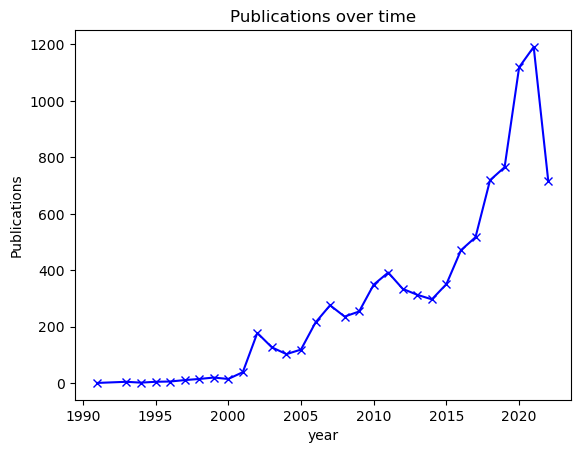

In [20]:
plt.plot([el[0] for el in year_freq], [el[1] for el in year_freq], 'b-x')

plt.title('Publications over time')
plt.xlabel('year')
plt.ylabel('Publications')

plt.show()

Description/Source: The graph shows the evolution in the number of publications in the AI domain, in the EU (at least one author is affiliated to an EU organization). Data Source: OpenAIRE Graph

In [25]:
import pickle

with open(indicators_dir.joinpath("Science_1_1.pickle"), "wb") as fout:
    pickle.dump(year_freq, fout)

In [27]:
# "i01": "Count of scientific publications"
keys, values = list(zip(*year_freq))

# Save
jstruct.set_info(keys, values, ind="i01", sv="year")
jstruct.save()

#### 1.2.2. Share of publications in topics over time

In [28]:
topics_over_time = []

for yr in years:
    print(yr)
    publis_yr = OA_selected_publis.filter(OA_selected_publis["year"] == yr).select("id").rdd.flatMap(lambda x: x).collect()
    publis_yr = set(publis_yr)
    pos = [idx for idx,val in enumerate(corpus_LDA) if val in publis_yr]
    topics_over_time.append(np.sum(thetas_LDA[pos,:], axis=0).tolist()[0])

topics_over_time = np.array(topics_over_time)

1990


1991


1992


1993


1994


1995


1996


1997


1998


1999


2000


2001


2002


2003


2004


2005


2006


2007


2008


2009


2010


2011


2012


2013


2014


2015


2016


2017


2018


2019


2020


2021


2022


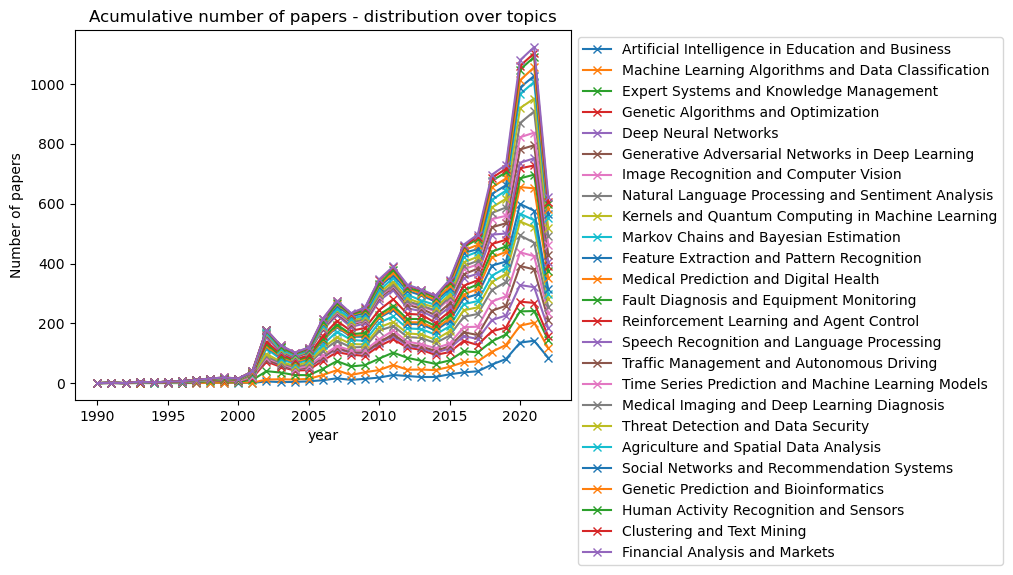

In [29]:
import seaborn as sns

cumulative = np.cumsum(topics_over_time, axis=1)

plt.plot(years, cumulative, 'x-')
# Configuración de etiquetas de ejes
plt.xlabel('year')
plt.ylabel('Number of papers')
plt.title('Acumulative number of papers - distribution over topics')
plt.legend(topics_LDA, bbox_to_anchor=(1, 1))

# Mostrar el gráfico
plt.show()

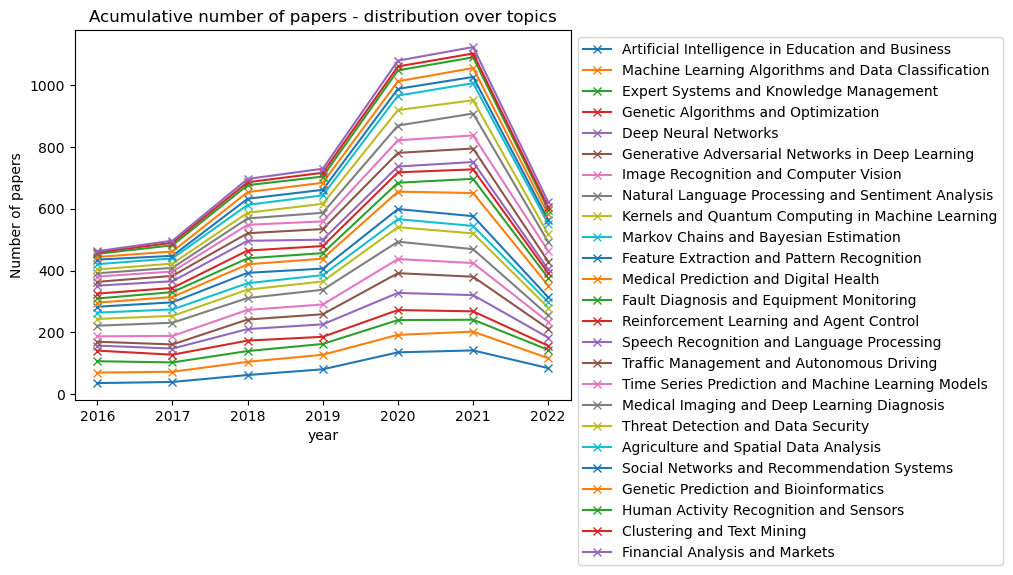

In [30]:
import seaborn as sns

cumulative = np.cumsum(topics_over_time, axis=1)

plt.plot(years[26:], cumulative[26:,], 'x-')
# Configuración de etiquetas de ejes
plt.xlabel('year')
plt.ylabel('Number of papers')
plt.title('Acumulative number of papers - distribution over topics')
plt.legend(topics_LDA, bbox_to_anchor=(1, 1))

# Mostrar el gráfico
plt.show()

In [31]:
data = {
    "years" : years,
    "topics_over_time" : topics_over_time,
    "cumulative" : cumulative,
    "topics_LDA" : topics_LDA
}

with open(indicators_dir.joinpath("Science_1_2.pickle"), "wb") as fout:
    pickle.dump(data, fout)

In [32]:
# Save
jstruct.set_info(keys=topics_LDA, values=topics_over_time.T, ind="i01", sv="topic", years=years)
jstruct.save()

#### 1.2.3. Open Access publications over time

In [33]:
results = spark.read.parquet(path2openAIRE + "result")
results = results.drop("dateofcollection").drop("language").drop("type").drop("embargoenddate").drop("dateofacceptance").drop("publisher")
results = results.filter(results["bestaccessrights"] == "Open Access").cache()

selected_open = OA_selected_publis.join(results, on="id", how="inner").dropDuplicates(["id"])
print('Number of Open Access publications', selected_open.count())

23/09/21 12:16:19 WARN SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 262144000 bytes). This may impact query planning performance.


Number of Open Access publications 5520


In [34]:
all_years = selected_open.select("year").rdd.flatMap(lambda x: x).collect()

In [35]:
year_freq_open = Counter(all_years)
year = list(year_freq_open.keys())
freq = list(year_freq_open.values())
year_freq_open = sorted([(el1, el2) for el1, el2 in zip(year,freq)], key=lambda x: x[0])

In [36]:
selected_open_journals = selected_open.filter(selected_open["journal"].isNotNull())
print('Number of Open Access publications (journals only)', selected_open_journals.count())

Number of Open Access publications (journals only) 2194


In [37]:
all_years = selected_open_journals.select("year").rdd.flatMap(lambda x: x).collect()

In [38]:
year_freq_open_journals = Counter(all_years)
year = list(year_freq_open_journals.keys())
freq = list(year_freq_open_journals.values())
year_freq_open_journals = sorted([(el1, el2) for el1, el2 in zip(year,freq)], key=lambda x: x[0])

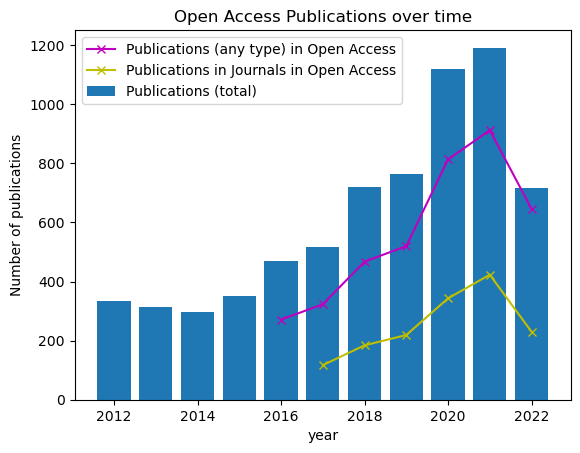

In [39]:
plt.bar([el[0] for el in year_freq][20:], [el[1] for el in year_freq][20:])
plt.plot([el[0] for el in year_freq_open][20:], [el[1] for el in year_freq_open][20:],'m-x')
plt.plot([el[0] for el in year_freq_open_journals][20:], [el[1] for el in year_freq_open_journals][20:],'y-x')

plt.title('Open Access Publications over time')
plt.xlabel('year')
plt.ylabel('Number of publications')

plt.legend(["Publications (any type) in Open Access", "Publications in Journals in Open Access", "Publications (total)"])

plt.show()

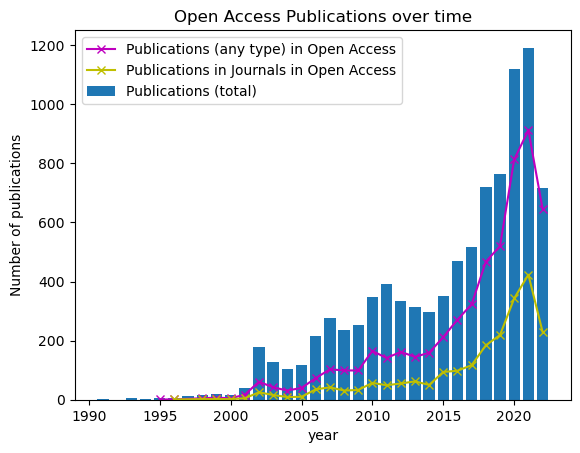

In [40]:
plt.bar([el[0] for el in year_freq], [el[1] for el in year_freq])
plt.plot([el[0] for el in year_freq_open], [el[1] for el in year_freq_open],'m-x')
plt.plot([el[0] for el in year_freq_open_journals], [el[1] for el in year_freq_open_journals],'y-x')

plt.title('Open Access Publications over time')
plt.xlabel('year')
plt.ylabel('Number of publications')

plt.legend(["Publications (any type) in Open Access", "Publications in Journals in Open Access", "Publications (total)"])

plt.show()

In [41]:
data = {
    "year_freq": year_freq,
    "year_freq_open": year_freq_open,
    "year_freq_open_journals": year_freq_open_journals
}

with open(indicators_dir.joinpath("Science_1_3.pickle"), "wb") as fout:
    pickle.dump(data, fout)

In [42]:
# Save
keys, values = list(zip(*year_freq_open))
jstruct.set_info(keys, values, ind="i23", sv="year")
jstruct.save()

keys, values = list(zip(*year_freq_open_journals))
jstruct.set_info(keys, values, ind="i23b", sv="year")
jstruct.save()

### 1.3. Scientific Production Origins

#### 1.3.1. Publications by Country

In [43]:
all_countries = OA_selected_publis.select("countries").rdd.flatMap(lambda x: x).collect()

In [44]:
flat_list = [el for sublist in all_countries for el in sublist]

In [45]:
country_freq = Counter(flat_list)
country = list(country_freq.keys())
freq = list(country_freq.values())
country_freq = {el1: el2 for el1, el2 in zip(country,freq)}

In [46]:
with open(indicators_dir.joinpath("Science_2_1.pickle"), "wb") as fout:
    pickle.dump(country_freq, fout)

In [47]:
# Save
jstruct.set_info(country_freq.keys(), country_freq.values(), ind="i01", sv="country")
jstruct.save()

#### 1.3.2. Publications by organization (top 100)

In [48]:
#Load organizations table
organization = spark.read.parquet(path2openAIRE + "organization").withColumnRenamed("id","organization").cache()
#print('Number of organization available:', organization.count())

# Load result_affiliation table
result_affiliation = spark.read.parquet(path2openAIRE + "result_affiliation").cache()
#print('Number of result_affiliation available:', result_affiliation.count())
# Keep only result_affiliation for the relevant papers
result_affiliation = result_affiliation.join(OA_selected_publis, on="id", how="inner").select(["id", "organization"])
# Count only each affiliation once (i.e., no se cuenta múltiples veces si hay varios investigadores de la misma organización)
result_affiliation = result_affiliation.dropDuplicates()

# Replace organization id by organization name
result_affiliation = result_affiliation.join(organization, on="organization", how="inner")
print('Number of organizations in the selected papers:', organization.count())

23/09/21 12:18:43 WARN CacheManager: Asked to cache already cached data.


Number of organizations in the selected papers: 314059


23/09/21 12:18:44 WARN CacheManager: Asked to cache already cached data.


Note this number is larger than the number of publications, as one publication can be attributed to more than one organization (but we only count organizations once per paper)

In [49]:
all_organizations = result_affiliation.select("name").rdd.flatMap(lambda x: x).collect()

organization_freq = Counter(all_organizations)

top100 = organization_freq.most_common(100)

for el, freq in top100:
    print(f"{el}: {freq}")

Universitat Politècnica de València: 854
University of Granada: 748
Universidad Politécnica de Madrid: 652
University of the Basque Country: 451
Universitat Politècnica de Catalunya: 446
Spanish National Research Council: 444
Universitat Politènica de Catalunya: 441
Carlos III University of Madrid: 393
University of Alicante: 317
University of Salamanca: 312
Complutense University of Madrid: 307
University of Valencia: 294
University of Seville: 289
University of Barcelona: 268
Pompeu Fabra University: 248
Autonomous University of Barcelona: 247
University of Malaga: 240
Autonomous University of Madrid: 239
Universidade de Vigo: 208
University of A Coruña: 204
Université Paris Diderot: 182
University of Alcalá: 174
University of Valladolid: 163
Instituto de Salud Carlos III: 163
University of Zaragoza: 160
University of Oviedo: 152
National University of Distance Education: 142
University of Santiago de Compostela: 141
University of Jaén: 136
University of Extremadura: 132
King Juan Ca

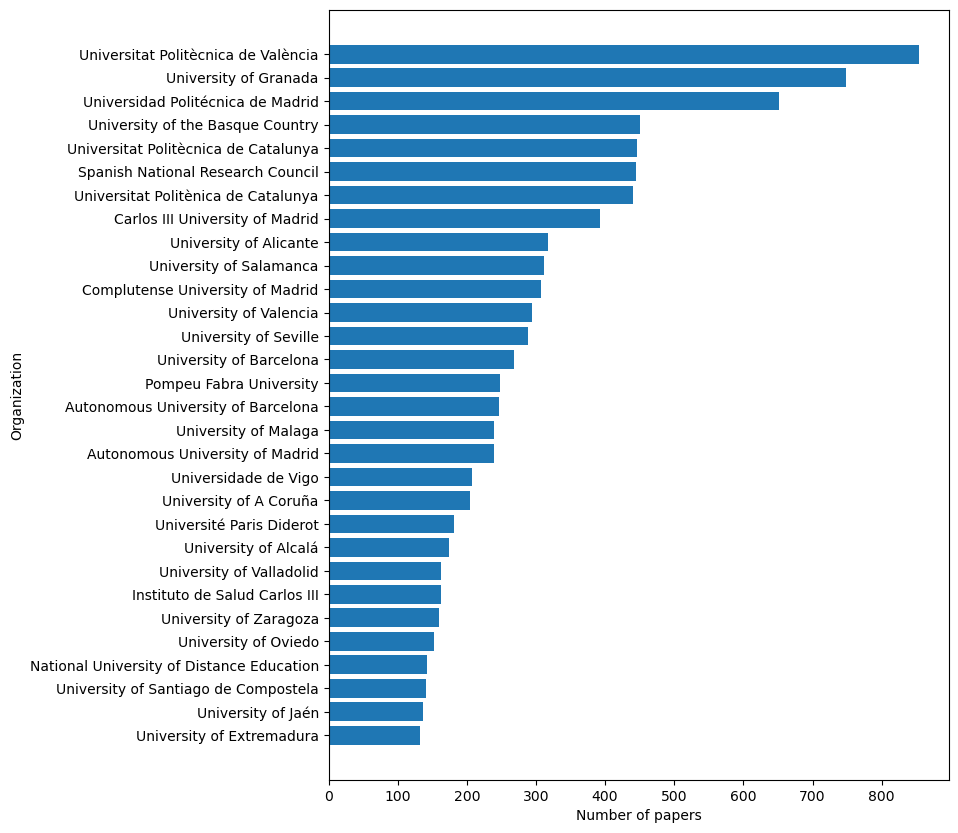

In [50]:
orgs = [el for el, _ in top100]
freqs = [freq for _, freq in top100]

plt.figure(figsize=(8, 10)) 
plt.barh(orgs[:30], freqs[:30])

plt.xlabel('Number of papers')
plt.ylabel('Organization')
plt.gca().invert_yaxis()  # Invert y axis

plt.show()

In [51]:
with open(indicators_dir.joinpath("Science_2_2.pickle"), "wb") as fout:
    pickle.dump(organization_freq, fout)

In [52]:
# Save
jstruct.set_info(orgs, freqs, ind="i01", sv="organization")
jstruct.save()

#### 1.3.3. Publications by Funder

In [53]:
# Load table of acknowledgements, and keep only the ones that are relevant for the selected papers
result_project = spark.read.parquet(path2openAIRE + "result_project")
result_project = result_project.join(OA_selected_publis, on="id", how="inner").select(["id", "project"]).cache()
print('Number of acknowledgments available:', result_project.count())

# Load table of projects and fill in the information regarding the funders of each project
project_funding = spark.read.parquet(path2openAIRE + "project_funding").withColumnRenamed("id","project").cache()
result_funder = result_project.join(project_funding, on="project", how="inner")

Number of acknowledgments available: 1809


In [54]:
all_funders = result_funder.select("funder").rdd.flatMap(lambda x: x).collect()

funders_freq = Counter(all_funders)

top100 = funders_freq.most_common(100)

for el, freq in top100:
    print(f"{el}: {freq}")

European Commission: 1049
National Institutes of Health: 99
National Science Foundation: 81
Fundação para a Ciência e a Tecnologia, I.P.: 39
UK Research and Innovation: 28
Swiss National Science Foundation: 20
Netherlands Organisation for Scientific Research (NWO): 19
French National Research Agency (ANR): 19
Natural Sciences and Engineering Research Council of Canada: 12
Wellcome Trust: 11
Canadian Institutes of Health Research: 10
Academy of Finland: 8
CHIST-ERA: 6
National Health and Medical Research Council (NHMRC): 5
Science Foundation Ireland: 4
Ministry of Education, Science and Technological Development of Republic of Serbia: 2
Australian Research Council (ARC): 2
Croatian Science Foundation (CSF): 2
Austrian Science Fund (FWF): 2


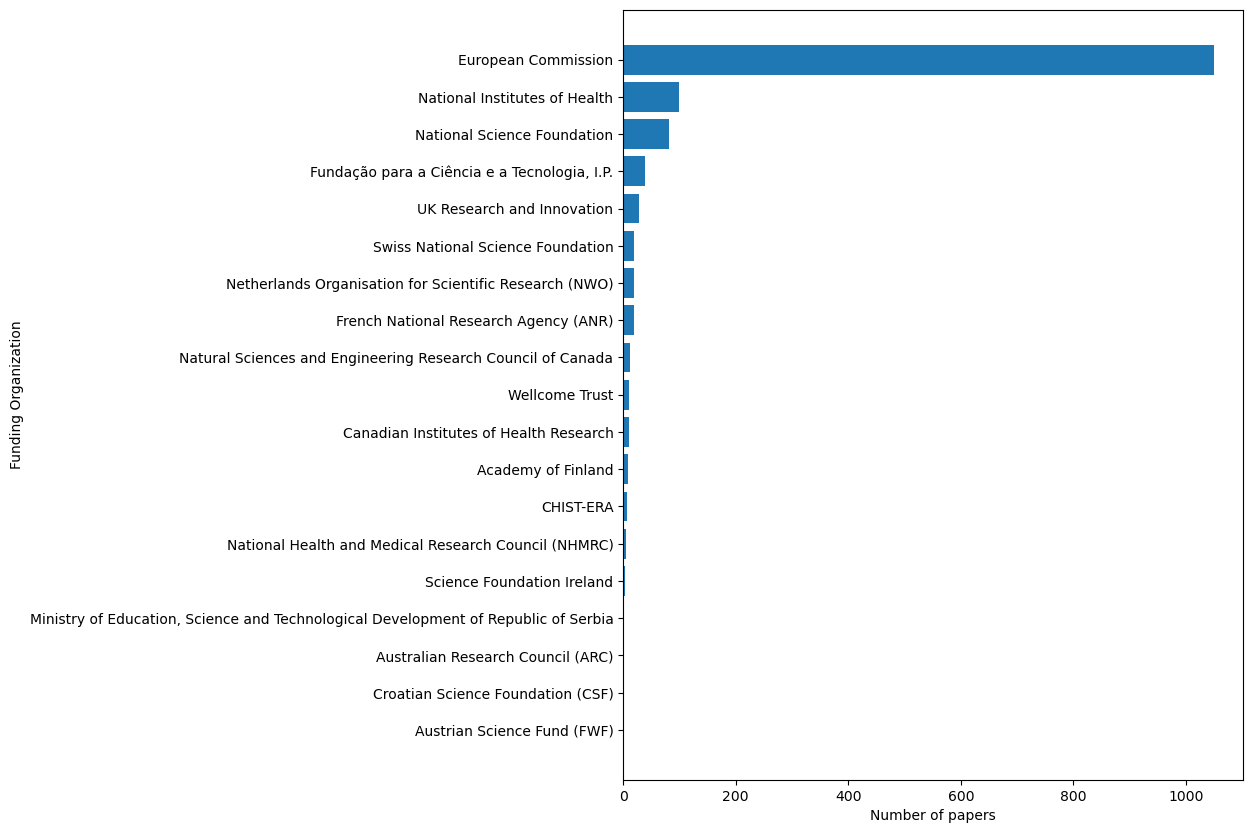

In [55]:
funder = [el for el, _ in top100]
freqs = [freq for _, freq in top100]

plt.figure(figsize=(8, 10))
plt.barh(funder[:30], freqs[:30])

plt.xlabel('Number of papers')
plt.ylabel('Funding Organization')
plt.gca().invert_yaxis()  # Invert y axis

plt.show()

In [56]:
with open(indicators_dir.joinpath("Science_2_3.pickle"), "wb") as fout:
    pickle.dump(funders_freq, fout)

In [57]:
# Save
jstruct.set_info(funder, freqs, ind="i01", sv="funder")
jstruct.save()

### 1.4. Scientific Production Characteristics

#### 1.4.1. Top 50 Journals

In [58]:
result = spark.read.parquet(path2openAIRE + "result").cache()
result = result.filter(F.col("journal").isNotNull())

# Keep only result results in the selected target dataset
result = result.join(OA_selected_publis, on="id", how="inner")

print('Number of results in journals:', result.count())

Number of results in journals: 4387


In [59]:
all_journals = result.select("journal").rdd.flatMap(lambda x: x).collect()

journals_freq = Counter(all_journals)

top100 = journals_freq.most_common(100)

for el, freq in top100:
    print(f"{el}: {freq}")

Expert Systems with Applications: 160
IEEE Access: 94
Neurocomputing: 81
Sensors: 66
Applied Soft Computing: 59
Information Sciences: 58
Knowledge-Based Systems: 53
Applied Sciences: 38
Pattern Recognition Letters: 33
Pattern Recognition: 29
Engineering Applications of Artificial Intelligence: 28
Sensors (Basel, Switzerland): 26
Remote Sensing: 24
SSRN Electronic Journal: 22
Computer Methods and Programs in Biomedicine: 22
PLoS ONE: 21
Information Fusion: 21
IEEE Transactions on Evolutionary Computation: 20
International Journal of Approximate Reasoning: 20
Speech Communication: 18
Computer methods and programs in biomedicine: 17
Environmental Modelling &amp; Software: 17
Scientific Reports: 16
Future Generation Computer Systems: 15
Computers and Electronics in Agriculture: 15
Journal of Biomedical Informatics: 14
Entropy: 14
Computer Speech &amp; Language: 14
BMC Bioinformatics: 14
International Journal of Uncertainty, Fuzziness and Knowledge-Based Systems: 13
IFAC Proceedings Volumes

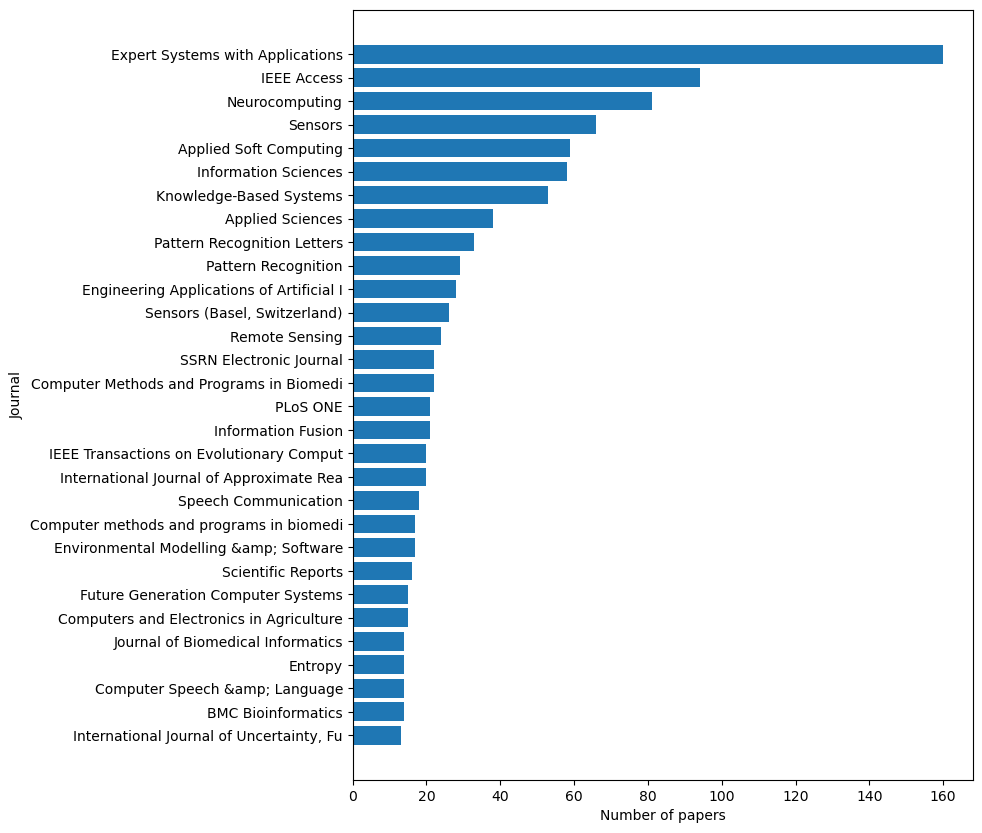

In [60]:
journal = [el[:40] for el, _ in top100]
freqs = [freq for _, freq in top100]

plt.figure(figsize=(8, 10))  # Ajusta el tamaño del gráfico según tus preferencias
plt.barh(journal[:30], freqs[:30])

# Personaliza el gráfico
plt.xlabel('Number of papers')
plt.ylabel('Journal')
plt.gca().invert_yaxis()  # Invierte el eje y para mostrar los elementos más frecuentes arriba

# Muestra el gráfico
plt.show()

In [61]:
with open(indicators_dir.joinpath("Science_3_2.pickle"), "wb") as fout:
    pickle.dump(journals_freq, fout)

In [62]:
# Save
jstruct.set_info(journal, freqs, ind="i01", sv="journal")
jstruct.save()

### 1.5. Scientific impact trends 

#### 1.5.1. Publications cited in patents

In [63]:
# We start loading dois for the selected publications
result_instance_pid = spark.read.parquet(path2openAIRE + "result_instance_pid")
result_instance_pid = result_instance_pid.filter(result_instance_pid["type"] == "Digital Object Identifier")
result_instance_pid = result_instance_pid.select(["result", "pid"]).withColumnRenamed("result","id").withColumnRenamed("pid", "doi")
OA_selected_publis_doi = OA_selected_publis.join(result_instance_pid, on="id", how="inner").cache()

print('Number of publications with dois:',OA_selected_publis_doi.count())

Number of publications with dois: 13319


In [64]:
npl_citations = spark.read.parquet(path2PATSTAT + "npl_citations.parquet").select("npl_doi").withColumnRenamed("npl_doi", "doi").cache()
npl_citations = npl_citations.filter(F.col("doi").isNotNull())
print('Number of NPL citations with DOI:', npl_citations.count())

Number of NPL citations with DOI: 1938151


In [65]:
OA_selected_publis_patstat = OA_selected_publis_doi.join(npl_citations, on="doi", how="inner").dropDuplicates(["id"])
print('Number of publications cited in PATSTAT:', OA_selected_publis_patstat.count())

Number of publications cited in PATSTAT: 53


In [66]:
all_years_npl = OA_selected_publis_patstat.select("year").rdd.flatMap(lambda x: x).collect()

In [67]:
npl_freq = Counter(all_years_npl)

year = list(npl_freq.keys())
freq = list(npl_freq.values())

npl_freq = sorted([(el1, el2) for el1, el2 in zip(year,freq)], key=lambda x: x[0])

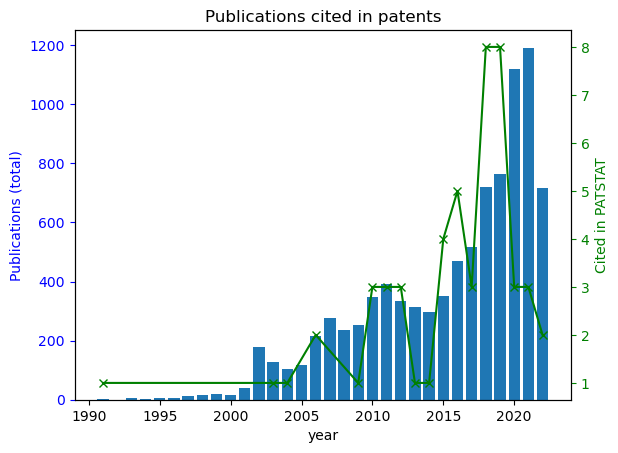

In [68]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.bar([el[0] for el in year_freq], [el[1] for el in year_freq], label="Publications (total)")
ax1.set_xlabel('year')
ax1.set_ylabel('Publications (total)', color='b')
ax1.tick_params('y', colors='b')

ax2.plot([el[0] for el in npl_freq], [el[1] for el in npl_freq], 'g-x', label="Publications cited in patents")
ax2.set_ylabel('Cited in PATSTAT', color='g')
ax2.tick_params('y', colors='g')

plt.title("Publications cited in patents")
plt.show()

In [69]:
data = {
    "year_freq" : year_freq,
    "npl_freq"  : npl_freq
}

with open(indicators_dir.joinpath("Science_4_1.pickle"), "wb") as fout:
    pickle.dump(data, fout)

In [70]:
keys, values = list(zip(*npl_freq))

# Save
jstruct.set_info(keys, values, ind="i13a", sv="year")
jstruct.save()

#### 1.5.2. Total citations over time

In [71]:
# We extend OA_selected_publis to contain the number of citations for each publication
# We create a dataframe that contains just the ids of the cited papers
result_citations = spark.read.parquet(path2openAIRE + "result_citations").select(["target"]).withColumnRenamed("target", "id")
result_citations = result_citations.join(OA_selected_publis, on="id", how="inner").select(["id"])
# We count the number of citations received by each paper
n_citations = result_citations.groupBy("id").agg(F.count("*").alias("citations"))

# Finally, we merge with the original dataframe with selected publications. We fill with 0s for papers without citations
OA_selected_publis_citations = OA_selected_publis.join(n_citations, on="id", how="left").na.fill(0, subset=["citations"]).cache()

In [72]:
print('Number of papers:', OA_selected_publis_citations.count())
OA_selected_publis_citations.printSchema()
OA_selected_publis_citations.show(n=2, truncate=120, vertical=True)

Number of papers: 9162
root
 |-- id: string (nullable = true)
 |-- countries: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- year: integer (nullable = true)
 |-- citations: long (nullable = true)

-RECORD 0---------------------------------------------------
 id        | dedup_wf_001::34646d9d0a7cc2b44675869dfa066d36 
 countries | [ES]                                           
 year      | 2014                                           
 citations | 0                                              
-RECORD 1---------------------------------------------------
 id        | dedup_wf_001::5deef3cb3377834e8c9fb3e6977ef2b3 
 countries | [ES]                                           
 year      | 2009                                           
 citations | 0                                              
only showing top 2 rows



In [75]:
# We aggregate the number of citations per year
sum_citations_df = OA_selected_publis_citations.groupBy("year").agg(F.sum("citations").alias("total_citations"))

# And collect the results in a dictionary
sum_citations_dict = sum_citations_df.rdd.collectAsMap()

# Finally, we create a list with the number of citations per year, sorted according to year
citations_total = []
for el in years:
    if el in sum_citations_dict:
        citations_total.append(sum_citations_dict[el])
    else:
        citations_total.append(0)

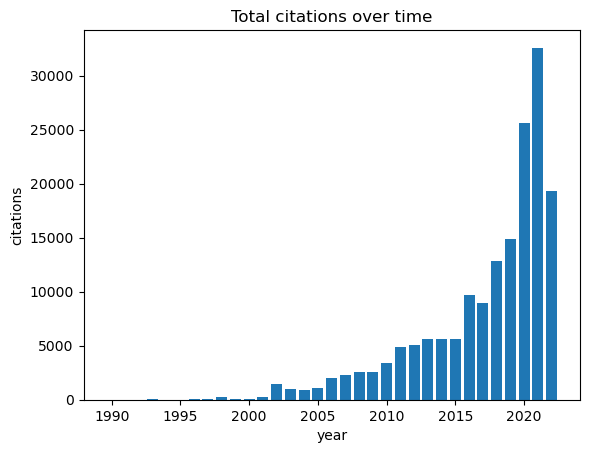

In [77]:
plt.bar(years, citations_total)

plt.title('Total citations over time')
plt.xlabel('year')
plt.ylabel('citations')

plt.show()

In [78]:
data = {
    "years" : years,
    "citations_total" : citations_total
}

with open(indicators_dir.joinpath("Science_4_3.pickle"), "wb") as fout:
    pickle.dump(data, fout)

In [79]:
# Save
jstruct.set_info(years, citations_total, ind="i06", sv="year")
jstruct.save()

#### 1.5.3. Average citations over time

In [81]:
# We average the number of citations per year
avg_citations_df = OA_selected_publis_citations.groupBy("year").agg(F.avg("citations").alias("average_citations"))

# And collect the results in a dictionary
avg_citations_dict = avg_citations_df.rdd.collectAsMap()

# Finally, we create a list with the number of citations per year, sorted according to year
citations_average = []

for el in years:
    if el in avg_citations_dict:
        citations_average.append(avg_citations_dict[el])
    else:
        citations_average.append(0)

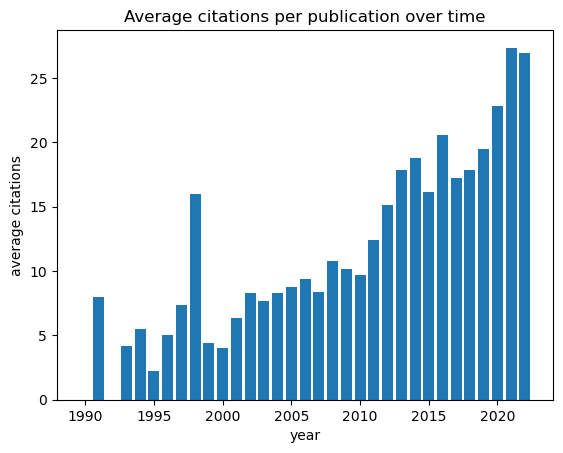

In [82]:
# Beware there are some elements out of range

plt.bar(years, citations_average)

plt.title('Average citations per publication over time')
plt.xlabel('year')
plt.ylabel('average citations')

plt.show()

In [83]:
data = {
    "years" : years,
    "citations_average" : citations_average
}

with open(indicators_dir.joinpath("Science_4_2.pickle"), "wb") as fout:
    pickle.dump(data, fout)

In [84]:
# Save
jstruct.set_info(years, citations_average, ind="i07", sv="year")
jstruct.save()

### 1.6. Scientific impact origin

#### 1.6.1. Total and average number of citations by country

In [85]:
# We start by generating a new dataframe where each publication is counted separately for each country
citations_country = OA_selected_publis_citations.select(F.explode("countries").alias("country"), "citations").cache()

In [86]:
# We aggregate the number of citations per country
sum_citations_country_df = citations_country.groupBy("country").agg(F.sum("citations").alias("total_citations"))

# And collect the results in a dictionary
sum_citations_country_dict = sum_citations_country_df.rdd.collectAsMap()

In [87]:
# For the average we request a minimum number of publications to be taken into account
min_results_per_country = 100

country_counts = citations_country.groupBy("country").agg(F.count("*").alias("count"))
country_keep = country_counts.filter(country_counts["count"] >= min_results_per_country).select(["country"])
citations_country = citations_country.join(country_keep, on = "country", how = "inner")

# We average the number of citations per country
avg_citations_country_df = citations_country.groupBy("country").agg(F.avg("citations").alias("average_citations"))

# And collect the results in a dictionary
avg_citations_country_dict = avg_citations_country_df.rdd.collectAsMap()

In [88]:
data = {
    "sum_citations_country_dict" : sum_citations_country_dict,
    "avg_citations_country_dict" : avg_citations_country_dict
}

with open(indicators_dir.joinpath("Science_5_1.pickle"), "wb") as fout:
    pickle.dump(data, fout)

In [89]:
# Save
jstruct.set_info(sum_citations_country_dict.keys(), sum_citations_country_dict.values(), ind="i06", sv="country")
jstruct.save()

# Save
jstruct.set_info(avg_citations_country_dict.keys(), avg_citations_country_dict.values(), ind="i07", sv="country")
jstruct.save()

#### 1.6.2. Average number of citations per publication by organization (top 100)

In [90]:
# Load table with all organizations
organization = spark.read.parquet(path2openAIRE + "organization").withColumnRenamed("id","organization")

# We load the list of result_affiliation
result_affiliation = spark.read.parquet(path2openAIRE + "result_affiliation")

# Next to each result and its affiliation, we copy the corresponding number of citations
result_affiliation = result_affiliation.join(OA_selected_publis_citations, on="id", how="inner").select(["organization", "citations"])

# Replace organization id by organization name
result_affiliation = result_affiliation.join(organization, on="organization", how="inner").select(["name", "citations"]).cache()

print('Number of result_affiliation available:', result_affiliation.count())
result_affiliation.printSchema()
result_affiliation.show(n=4, truncate=120, vertical=True)

Number of result_affiliation available: 22432
root
 |-- name: string (nullable = true)
 |-- citations: long (nullable = true)

-RECORD 0------------------------------------------------------------------------
 name      | ROYAL INSTITUTION FOR THE ADVANCEMENT OF LEARNING MCGILL UNIVERSITY 
 citations | 0                                                                   
-RECORD 1------------------------------------------------------------------------
 name      | STICHTING EPILEPSIE INSTELLINGEN NEDERLAND                          
 citations | 12                                                                  
-RECORD 2------------------------------------------------------------------------
 name      | AUS (United States)                                                 
 citations | 20                                                                  
-RECORD 3------------------------------------------------------------------------
 name      | University of Carthage                  

In [91]:
# We aggregate the number of citations per organization
sum_citations_organization_df = result_affiliation.groupBy("name").agg(F.sum("citations").alias("total_citations"))

# And collect the results in a dictionary
sum_citations_organization_dict = sum_citations_organization_df.rdd.collectAsMap()

# Sort results, and keep only top 100 institutions
sum_citations_organization_dict = sorted([(el[0], el[1]) for el in sum_citations_organization_dict.items()], key=lambda x: -x[1])[:100]

In [92]:
# For the average we request a minimum number of publications to be taken into account
min_results_per_org = 25

org_counts = result_affiliation.groupBy("name").agg(F.count("*").alias("count"))
org_keep = org_counts.filter(org_counts["count"] >= min_results_per_org).select(["name"])
result_affiliation = result_affiliation.join(org_keep, on = "name", how = "inner")

# We average the number of citations per organization
avg_citations_organization_df = result_affiliation.groupBy("name").agg(F.avg("citations").alias("average_citations"))

# And collect the results in a dictionary
avg_citations_organization_dict = avg_citations_organization_df.rdd.collectAsMap()

# Sort results, and keep only top 100 institutions
avg_citations_organization_dict = sorted([(el[0], el[1]) for el in avg_citations_organization_dict.items()], key=lambda x: -x[1])[:100]

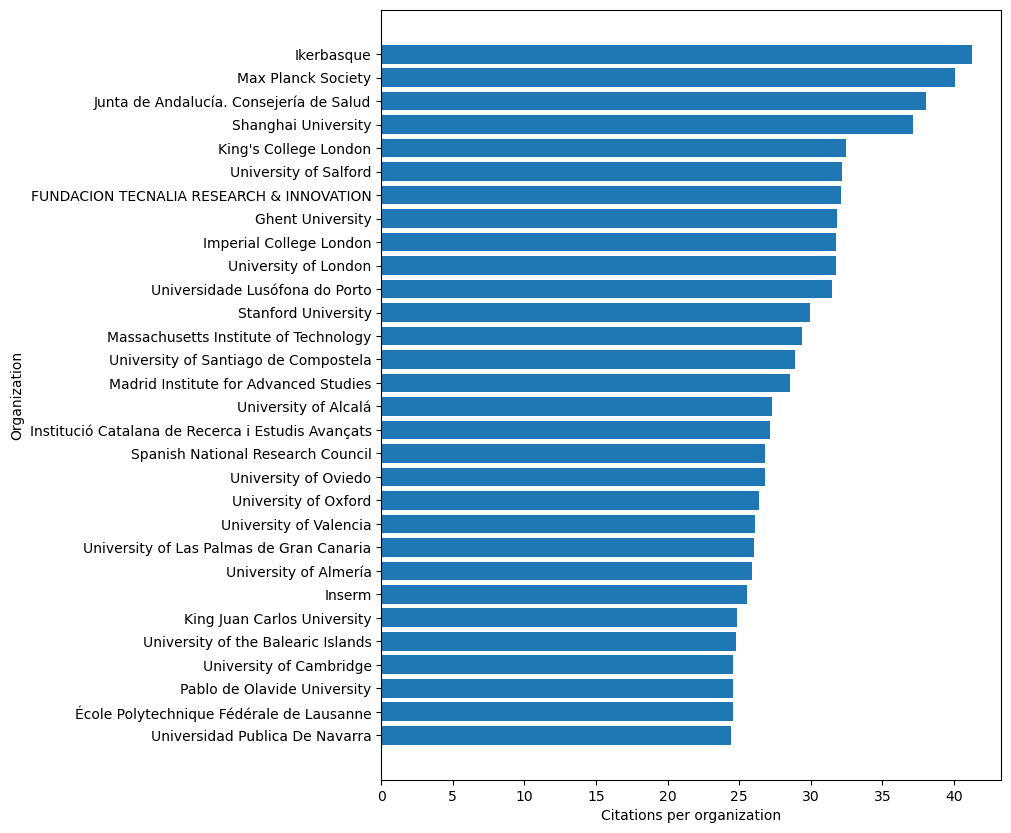

In [93]:
orgs, freqs = zip(*avg_citations_organization_dict)

plt.figure(figsize=(8, 10))  
plt.barh(orgs[:30], freqs[:30])

plt.xlabel('Citations per organization')
plt.ylabel('Organization')
plt.gca().invert_yaxis()  # Invert y axis

plt.show()

In [94]:
data = {
    "sum_citations_organization_dict" : sum_citations_organization_dict,
    "avg_citations_organization_dict" : avg_citations_organization_dict
}

with open(indicators_dir.joinpath("Science_5_2.pickle"), "wb") as fout:
    pickle.dump(data, fout)

In [95]:
# Save average values
jstruct.set_info(orgs, freqs, ind="i07", sv="organization")
jstruct.save()

# Save total values
orgs, freqs = zip(*sum_citations_organization_dict)
jstruct.set_info(orgs, freqs, ind="i06", sv="organization")
jstruct.save()


#### 1.6.3. Average number of citations per publication by funder

In [96]:
result_project = spark.read.parquet(path2openAIRE + "result_project")
result_project = result_project.join(OA_selected_publis_citations, on="id", how="inner").select(["project", "citations"])

# Use project id to obtain the funder for each element
project_funding = spark.read.parquet(path2openAIRE + "project_funding").withColumnRenamed("id","project")
result_funder = result_project.join(project_funding, on="project", how="inner").select(["funder", "citations"]).cache()

print('Number of result_funder available:', result_funder.count())
result_funder.printSchema()
result_funder.show(n=4, truncate=120, vertical=True)

Number of result_funder available: 1418
root
 |-- funder: string (nullable = true)
 |-- citations: long (nullable = true)

-RECORD 0----------------------------------
 funder    | European Commission           
 citations | 5                             
-RECORD 1----------------------------------
 funder    | European Commission           
 citations | 10                            
-RECORD 2----------------------------------
 funder    | European Commission           
 citations | 7                             
-RECORD 3----------------------------------
 funder    | National Institutes of Health 
 citations | 25                            
only showing top 4 rows



In [97]:
# We aggregate the number of citations per funder
sum_citations_funder_df = result_funder.groupBy("funder").agg(F.sum("citations").alias("total_citations"))

# And collect the results in a dictionary
sum_citations_funder_dict = sum_citations_funder_df.rdd.collectAsMap()

# Sort results
sum_citations_funder = sorted([(el[0], el[1]) for el in sum_citations_funder_dict.items()], key=lambda x: -x[1])

In [98]:
# For the average we request a minimum number of publications to be taken into account
min_results_per_funder = 25

funder_counts = result_funder.groupBy("funder").agg(F.count("*").alias("count"))
funder_keep = funder_counts.filter(funder_counts["count"] >= min_results_per_funder).select(["funder"])
result_funder = result_funder.join(funder_keep, on = "funder", how = "inner")

# We average the number of citations per funder
avg_citations_funder_df = result_funder.groupBy("funder").agg(F.avg("citations").alias("average_citations"))

# And collect the results in a dictionary
avg_citations_funder_dict = avg_citations_funder_df.rdd.collectAsMap()

# Sort results
avg_citations_funder = sorted([(el[0], el[1]) for el in avg_citations_funder_dict.items()], key=lambda x: -x[1])

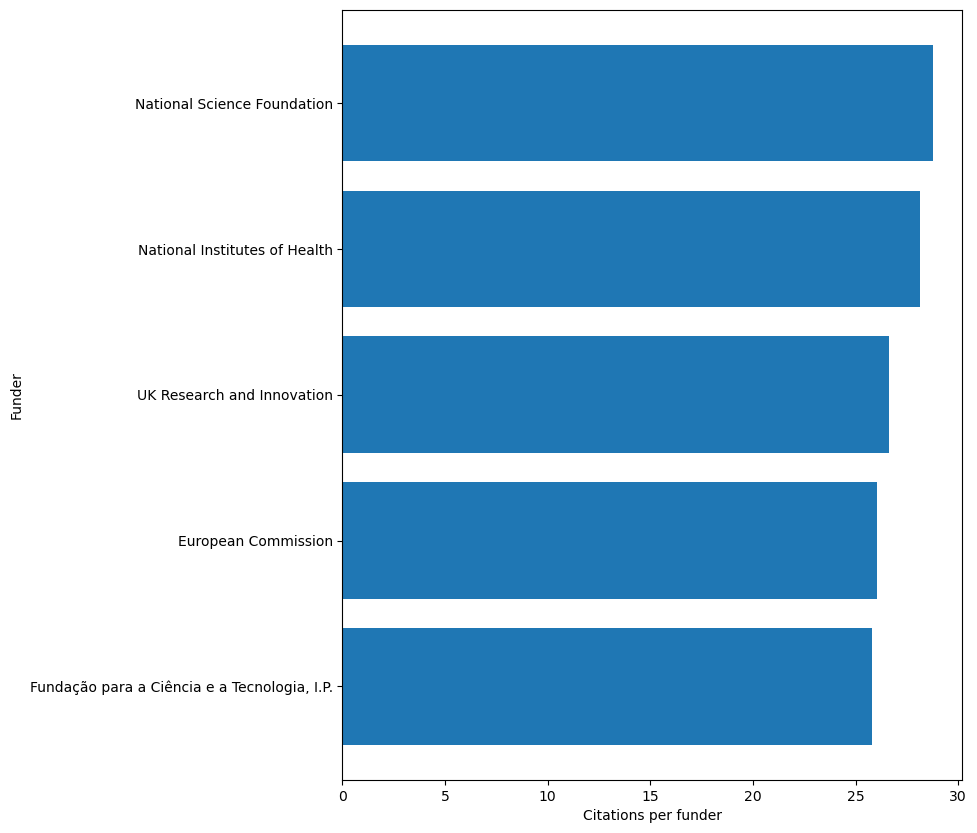

In [99]:
funder, freqs = zip(*avg_citations_funder)

plt.figure(figsize=(8, 10))  
plt.barh(funder[:30], freqs[:30])

plt.xlabel('Citations per funder')
plt.ylabel('Funder')
plt.gca().invert_yaxis()  # Invert y axis

plt.show()

In [100]:
data = {
    "sum_citations_funder_dict" : sum_citations_funder_dict,
    "avg_citations_funder_dict" : avg_citations_funder_dict
}

with open(indicators_dir.joinpath("Science_5_3.pickle"), "wb") as fout:
    pickle.dump(data, fout)

In [101]:
# Save average values
jstruct.set_info(funder, freqs, ind="i07", sv="funder")
jstruct.save()

# Save total values
funder, freqs = zip(*sum_citations_funder)
jstruct.set_info(funder, freqs, ind="i06", sv="funder")
jstruct.save()


### 1.7. Scientific impact characteristics

#### 1.7.1. Publications cited in patents by topic

In [102]:
# We can start from the OA_selOA_selected_publis_patstat dataframe, but according to the description of
# the indicator, both the publication and the patent where it is cited have to be in the domain and geographic context
# The target set of patents needs to be computed specific for each report (See e.g. Sec. 1.1.1.)

OA_selected_publis_patstat.printSchema()
patstat_target_IND71.printSchema()

root
 |-- doi: string (nullable = true)
 |-- id: string (nullable = true)
 |-- countries: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- year: integer (nullable = true)

root
 |-- appln_id: string (nullable = true)



In [103]:
# Therefore, we need to keep only a subset of the publications in OA_selected_publis_patstat
# We keep only those publications associated to patents in patstat_target_IND71

npl_citations = spark.read.parquet(path2PATSTAT + "npl_citations.parquet").select(["appln_id", "npl_doi"]).withColumnRenamed("npl_doi", "doi")
npl_citations = npl_citations.filter(F.col("doi").isNotNull())
npl_citations = npl_citations.join(patstat_target_IND71, on="appln_id", how="inner")

OA_selected_publis_patstat_IND71 = OA_selected_publis_patstat.join(npl_citations, on="doi", how="inner").dropDuplicates(["id"]).cache()

print("Number of publications that are used for Publications cited in patents by topic:", OA_selected_publis_patstat_IND71.count())
OA_selected_publis_patstat_IND71.printSchema()

Number of publications that are used for Publications cited in patents by topic: 5
root
 |-- doi: string (nullable = true)
 |-- id: string (nullable = true)
 |-- countries: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- year: integer (nullable = true)
 |-- appln_id: string (nullable = true)



In [104]:
# We calculate the distribution of topics in this subste of publications
relevant_publis = OA_selected_publis_patstat_IND71.select("id").rdd.flatMap(lambda x: x).collect()
relevant_publis = set(relevant_publis)
pos = [idx for idx,val in enumerate(corpus_LDA) if val in relevant_publis]
publis_per_topic = np.sum(thetas_LDA[pos,:], axis=0).tolist()[0]

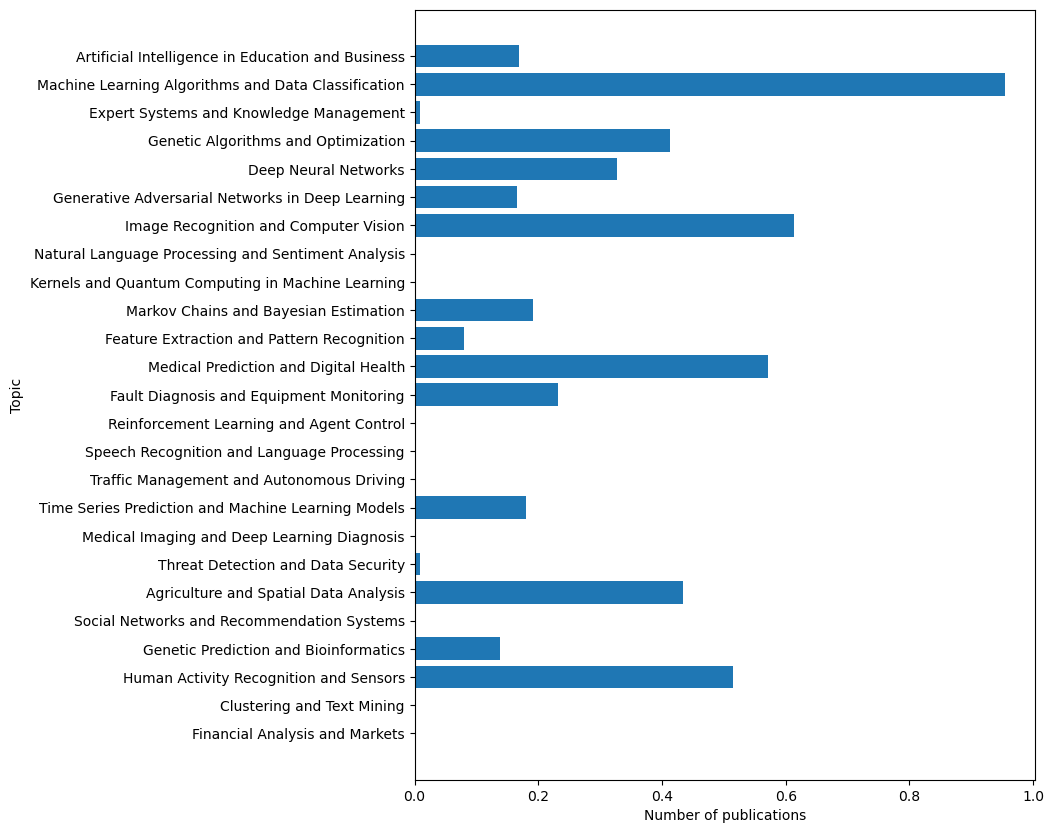

In [105]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 10)) 
plt.barh(topics_LDA, publis_per_topic)

plt.xlabel('Number of publications')
plt.ylabel('Topic')
plt.gca().invert_yaxis()  # Invert y axis
plt.show()

In [159]:
publis_in_patents_topic = {
    'topics_LDA' : topics_LDA,
    'publis_per_topic' : publis_per_topic
}

with open(indicators_dir.joinpath("Science_6_1.pickle"), "wb") as fout:
    pickle.dump(publis_in_patents_topic, fout)

In [160]:
# Save
jstruct.set_info(topics_LDA, publis_per_topic, ind="i13a", sv="topic")
jstruct.save()

#### 1.7.2. Citations per publication by topic

In [106]:
cit_counts_diccio = OA_selected_publis_citations.select("id", "citations").rdd.collectAsMap()

In [118]:
pos = []
counts = []

for idx,val in enumerate(corpus_LDA):
    if val in cit_counts_diccio:
        pos.append(idx)
        counts.append(cit_counts_diccio[val])

In [120]:
publis_per_topic = np.sum(thetas_LDA[pos,:], axis=0).tolist()[0]
av_cit_topic = (np.array(counts)*thetas_LDA[pos,:])/np.array(publis_per_topic)

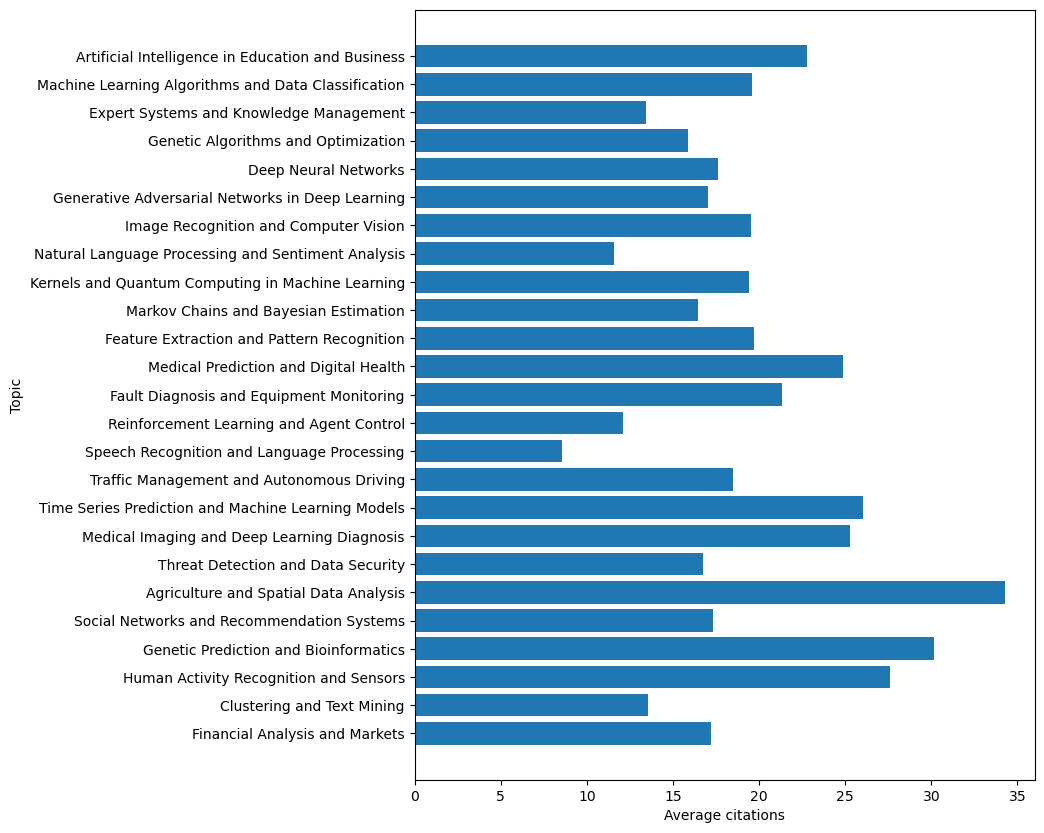

In [121]:
plt.figure(figsize=(8, 10)) 
plt.barh(topics_LDA, av_cit_topic)

plt.xlabel('Average citations')
plt.ylabel('Topic')
plt.gca().invert_yaxis() 

plt.show()

In [122]:
av_citations_data = {
    'topics_LDA' : topics_LDA,
    'av_cit_topic' : av_cit_topic
}

with open(indicators_dir.joinpath("Science_6_2.pickle"), "wb") as fout:
    pickle.dump(av_citations_data, fout)

In [123]:
# Save
jstruct.set_info(topics_LDA, av_cit_topic, ind="i07", sv="topic")
jstruct.save()

### 1.8. Scientific impact collaborations

#### 1.8.1. International Collaborations over time

In [124]:
# User defined function to count number of different countries in each publication
def filter_and_remove_duplicates(array):
    return len(set(filter(lambda x: x != "UNKNOWN", array)))

filter_and_remove_duplicates_udf = F.udf(filter_and_remove_duplicates, IntegerType())

# Count different countries in each publication
OA_selected_publis_citations = OA_selected_publis_citations.withColumn("n_countries", filter_and_remove_duplicates_udf(F.col("countries")))

In [125]:
# Count number of multicountry publications
all_years = OA_selected_publis_citations.select("year").rdd.flatMap(lambda x: x).collect()

# Count number of multicountry publications
OA_multicountry = OA_selected_publis_citations.filter(OA_selected_publis_citations["n_countries"] > 1)
all_years_multicountry = OA_multicountry.select("year").rdd.flatMap(lambda x: x).collect()

# Count now only those publications that have been cited
OA_multicountry_cited = OA_multicountry.filter(OA_multicountry["citations"] > 0)
all_years_multicountry_cit = OA_multicountry_cited.select("year").rdd.flatMap(lambda x: x).collect()

In [126]:
year_freq = Counter(all_years)
year = list(year_freq.keys())
freq = list(year_freq.values())
all_years = sorted([(el1, el2) for el1, el2 in zip(year,freq)], key=lambda x: x[0])

year_freq = Counter(all_years_multicountry)
year = list(year_freq.keys())
freq = list(year_freq.values())
all_years_multicountry = sorted([(el1, el2) for el1, el2 in zip(year,freq)], key=lambda x: x[0])

year_freq = Counter(all_years_multicountry_cit)
year = list(year_freq.keys())
freq = list(year_freq.values())
all_years_multicountry_cit = sorted([(el1, el2) for el1, el2 in zip(year,freq)], key=lambda x: x[0])

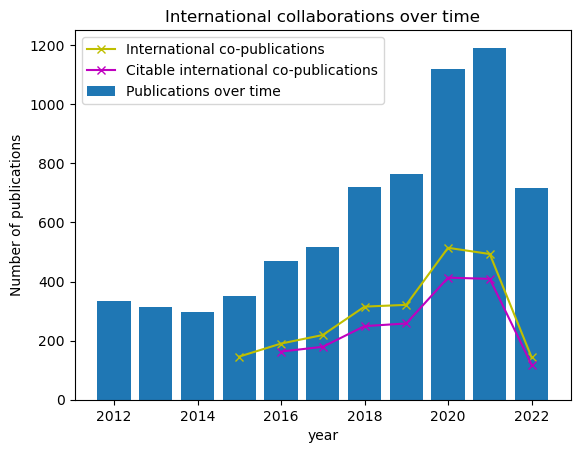

In [127]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot([el[0] for el in all_years_multicountry][20:], [el[1] for el in all_years_multicountry][20:],'y-x')
plt.plot([el[0] for el in all_years_multicountry_cit][20:], [el[1] for el in all_years_multicountry_cit][20:],'m-x')
plt.bar([el[0] for el in all_years][20:], [el[1] for el in all_years][20:])

plt.title('International collaborations over time')
plt.xlabel('year')
plt.ylabel('Number of publications')

plt.legend(["International co-publications", "Citable international co-publications", "Publications over time"])

plt.show()

In [128]:
intl_colab = {
    'all_years' : all_years,
    'all_years_multicountry' : all_years_multicountry,
    'all_years_multicountry_cit': all_years_multicountry_cit
}

with open(indicators_dir.joinpath("Science_7.1.pickle"), "wb") as fout:
    pickle.dump(intl_colab, fout)

In [129]:
# "i19": "Number of International co-publications"
keys, values = list(zip(*all_years_multicountry))

# Save
jstruct.set_info(keys, values, ind="i19", sv="year")
jstruct.save()

# "i20": "Number of cited international co-publications"
keys, values = list(zip(*all_years_multicountry_cit))

# Save
jstruct.set_info(keys, values, ind="i20", sv="year")
jstruct.save()

#### 1.8.2. International collaborations by topic

In [130]:
OA_multicountry_ids = OA_multicountry.select("id").rdd.flatMap(lambda x: x).collect()
relevant_publis = set(OA_multicountry_ids)
pos = [idx for idx,val in enumerate(corpus_LDA) if val in relevant_publis]
publis_per_topic = np.sum(thetas_LDA[pos,:], axis=0).tolist()[0]

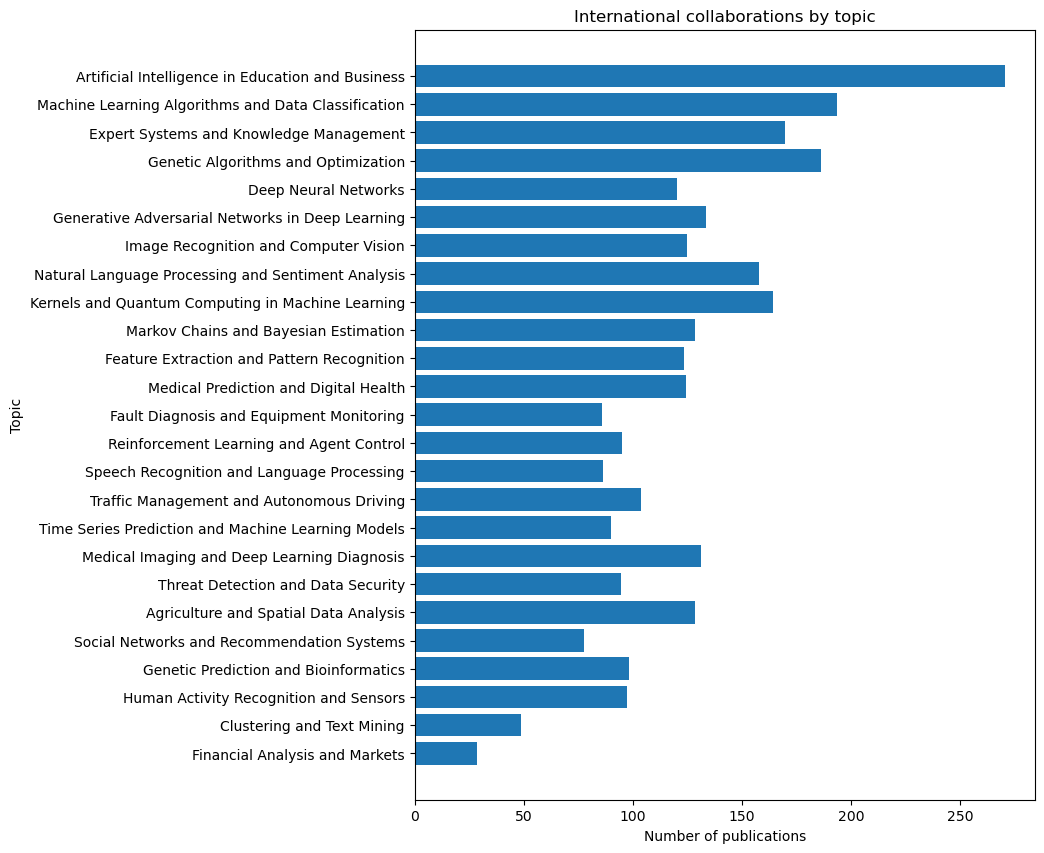

In [131]:
plt.figure(figsize=(8, 10))
plt.barh(topics_LDA, publis_per_topic)

plt.xlabel('Number of publications')
plt.ylabel('Topic')
plt.title('International collaborations by topic')
plt.gca().invert_yaxis()  # Invert axis

plt.show()

In [132]:
data = {
    "topics_LDA": topics_LDA,
    "publis_per_topic" : publis_per_topic
}

with open(indicators_dir.joinpath("Science_7.2.pickle"), "wb") as fout:
    pickle.dump(data, fout)

In [133]:
# Save
jstruct.set_info(topics_LDA, publis_per_topic, ind="i19", sv="topic")
jstruct.save()

## 2. Technology indicators

### 2.1. Load data for Analysis and Topic Model

#### 2.1.1. Artificial intelligence in EU

In [146]:
# Prepare structure for exporting the results

domain = "AI"
geography = "EU"
pv = "AI"

years = [el for el in range(1990, 2021)]

indicators_dir = Path("/export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/indicators/AI/EU/Technology")
jstruct = JSONstruct(domain, geography, pv, indicators_dir)

##### Load Topic Model variables

In [135]:
# Load topic model variables
path2model = "/export/usuarios_ml4ds/jarenas/github/IntelComp/ITMT/topicmodeler/WP6models/TMmodels/PATSTAT_Kwds3_AI_25tpc/"

with open(path2model + "corpus.txt") as fin:
    corpus_LDA = [el.split()[0].strip() for el in fin.readlines()]

thetas_LDA = sparse.load_npz(path2model + "TMmodel/thetas.npz")

with open(path2model + "TMmodel/tpc_labels.txt") as fin:
    topics_LDA = [el.strip() for el in fin.readlines()]

##### Load relevant patents from the AI domain from the EPO

In [142]:
# 1. Load all patents in AI
AI_patents_file = "file:///export/usuarios_ml4ds/jarenas/github/IntelComp/KPIs/WP3-pipelines/datasets/AI/PATSTAT_Kwds3_AI.parquet"
AI_patents_all = spark.read.parquet(AI_patents_file)

print('Number of patents with AI keywords:', AI_patents_all.count())

# 2. We keep only the patents that have been granted, and those presented through the EPO
AI_patents_granted = AI_patents_all.filter(F.col("granted") == "Y")
AI_patents_EU = AI_patents_granted.filter(F.col("appln_auth") == "EP")
print('Number of AI patents granted by EPO:', AI_patents_EU.count())

# 3. Finally we need to filter publications according to year interval. We add the year to the available info
AI_patents_EU = AI_patents_EU.withColumn("earliest_filing_year", F.col("earliest_filing_year").cast(IntegerType()))
AI_patents_EU = AI_patents_EU.filter(AI_patents_EU["earliest_filing_year"].isNotNull() & (AI_patents_EU["earliest_filing_year"] >= years[0]) & (AI_patents_EU["earliest_filing_year"] <= years[-1]))

Number of patents with AI keywords: 146022


Number of AI patents granted by EPO: 1113


In [143]:
# We are done, we just need to rename the dataframe. We show the number of records and structure of the dataframe
PATSTAT_selected = AI_patents_EU.cache()

print('Number of patents that will be used for the analysis:', PATSTAT_selected.count())
PATSTAT_selected.printSchema()
PATSTAT_selected.show(n=10, truncate=120, vertical=True)

Number of patents that will be used for the analysis: 1044
root
 |-- appln_id: string (nullable = true)
 |-- docdb_family_id: string (nullable = true)
 |-- appln_title: string (nullable = true)
 |-- appln_title_lg: string (nullable = true)
 |-- appln_abstract: string (nullable = true)
 |-- appln_abstract_lg: string (nullable = true)
 |-- appln_filing_year: string (nullable = true)
 |-- earliest_filing_year: integer (nullable = true)
 |-- granted: string (nullable = true)
 |-- appln_auth: string (nullable = true)
 |-- receiving_office: string (nullable = true)
 |-- ipr_type: string (nullable = true)
 |-- Kwd_count: integer (nullable = true)



-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------
 appln_id             | 274101009                                                                                                                
 docdb_family_id      | 41479094                                                                                                                 
 appln_title          | METHOD FOR ANALYZING MESSAGE ARCHIVES AND CORRESPONDING COMPUTER PROGRAM TO GENERATE A FINITE STATES MACHINE             
 appln_title_lg       | en                                                                                                                       
 appln_abstract       | The invention relates to a method for analyzing a large number of messages (28), wherein the number of messages is re... 
 appln_abstract_lg    | en                                                                                                  

### 2.2. Technological Production Trends

#### 2.2.1. Patents over time

In [147]:
year_count = PATSTAT_selected.groupBy("earliest_filing_year").agg(F.count("*").alias("counts")).rdd.collectAsMap()
pats_per_year = [year_count[el] for el in years]

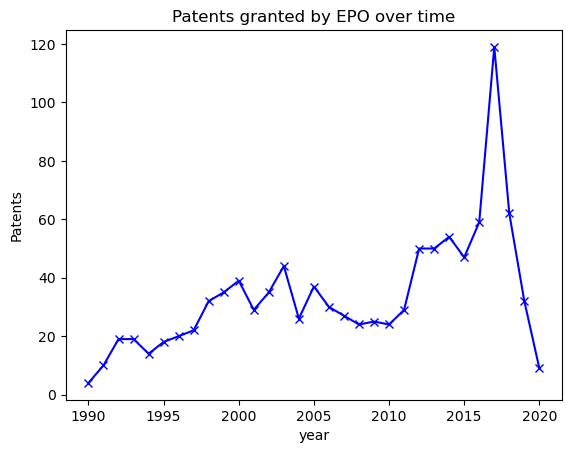

In [150]:
plt.plot(years, pats_per_year, 'b-x')

plt.title('Patents granted by EPO over time')
plt.xlabel('year')
plt.ylabel('Patents')

plt.show()

In [152]:
data = {
    "years" : years,
    "pats_per_year" : pats_per_year
}

with open(indicators_dir.joinpath("Technology_1_1.pickle"), "wb") as fout:
    pickle.dump(data, fout)

In [154]:
# Save
jstruct.set_info(years, pats_per_year, ind="i09", sv="year")
jstruct.save()

#### 2.2.2. Distribution by year of topics in patents to the EPO (by priority year)"

In [155]:
topics_over_time = []

for yr in years:
    print(yr)
    patents_yr = PATSTAT_selected.filter(PATSTAT_selected["earliest_filing_year"] == yr).select("appln_id").rdd.flatMap(lambda x: x).collect()
    patents_yr = set(patents_yr)
    pos = [idx for idx,val in enumerate(corpus_LDA) if val in patents_yr]
    topics_over_time.append(np.sum(thetas_LDA[pos,:], axis=0).tolist()[0])

topics_over_time = np.array(topics_over_time)

1990


1991


1992


1993


1994


1995


1996


1997


1998


1999


2000


2001


2002


2003


2004


2005


2006


2007


2008


2009


2010


2011


2012


2013


2014


2015


2016


2017


2018


2019


2020


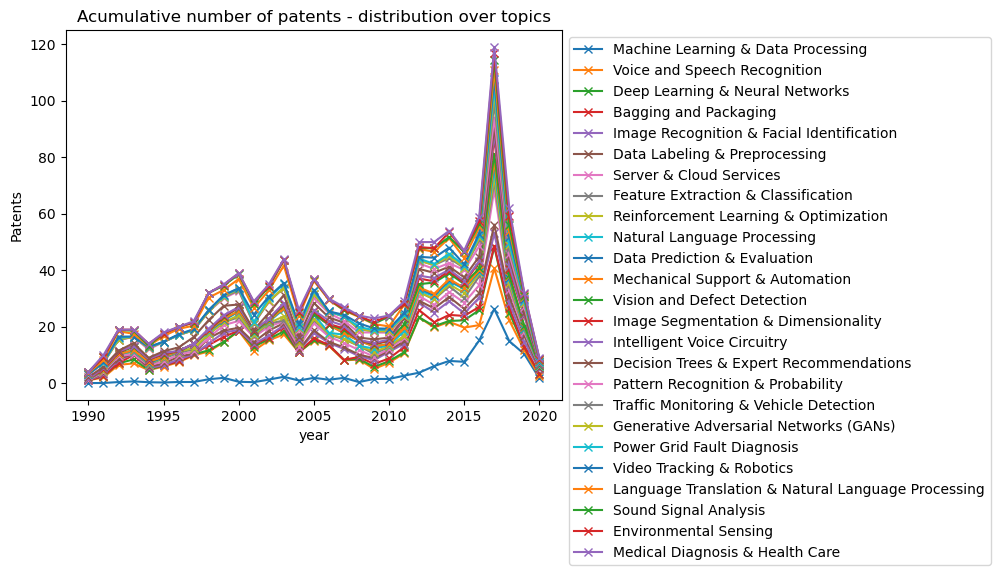

In [157]:
import seaborn as sns

cumulative = np.cumsum(topics_over_time, axis=1)

plt.plot(years, cumulative, 'x-')
# Configuración de etiquetas de ejes
plt.xlabel('year')
plt.ylabel('Patents')
plt.title('Acumulative number of patents - distribution over topics')
plt.legend(topics_LDA, bbox_to_anchor=(1, 1))

# Mostrar el gráfico
plt.show()

In [162]:
data = {
    "years" : years,
    "topics_over_time" : topics_over_time,
    "cumulative" : cumulative,
    "topics_LDA" : topics_LDA
}

with open(indicators_dir.joinpath("Technology_1_2.pickle"), "wb") as fout:
    pickle.dump(data, fout)

In [161]:
# Save
jstruct.set_info(keys=topics_LDA, values=topics_over_time.T, ind="i09b", sv="topic", years=years)
jstruct.save()

### 2.3. Technological production origins

In [170]:
# We start enriching the dataset with person information, including harmonized name, country, and sector
tls207 = spark.read.parquet(path2PATSTAT + "tls207.parquet").select(["appln_id", "person_id"])
PATSTAT_selected_person = PATSTAT_selected.join(tls207, on="appln_id", how="left")

tls206 = spark.read.parquet(path2PATSTAT + "tls206.parquet").select(["person_id", "psn_name", "psn_sector", "person_ctry_code"])
PATSTAT_selected_person = PATSTAT_selected_person.join(tls206, on="person_id", how="left").cache()

print("Number of patents incorporating person information:", PATSTAT_selected_person.count())
PATSTAT_selected_person.printSchema()
PATSTAT_selected_person.show(n=4, truncate=120, vertical=True)

Number of patents incorporating person information: 4004
root
 |-- person_id: string (nullable = true)
 |-- appln_id: string (nullable = true)
 |-- docdb_family_id: string (nullable = true)
 |-- appln_title: string (nullable = true)
 |-- appln_title_lg: string (nullable = true)
 |-- appln_abstract: string (nullable = true)
 |-- appln_abstract_lg: string (nullable = true)
 |-- appln_filing_year: string (nullable = true)
 |-- earliest_filing_year: integer (nullable = true)
 |-- granted: string (nullable = true)
 |-- appln_auth: string (nullable = true)
 |-- receiving_office: string (nullable = true)
 |-- ipr_type: string (nullable = true)
 |-- Kwd_count: integer (nullable = true)
 |-- psn_name: string (nullable = true)
 |-- psn_sector: string (nullable = true)
 |-- person_ctry_code: string (nullable = true)

-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------
 person_id            | 1249579     

#### 2.3.1. Patents by Country

In [175]:
PATSTAT_country = PATSTAT_selected_person.filter(PATSTAT_selected_person["person_ctry_code"].isNotNull()).select("person_ctry_code")
country_freq = PATSTAT_country.groupBy("person_ctry_code").agg(F.count("*").alias("counts")).rdd.collectAsMap()

In [178]:
with open(indicators_dir.joinpath("Technology_2_1.pickle"), "wb") as fout:
    pickle.dump(country_freq, fout)

In [177]:
# Save
jstruct.set_info(country_freq.keys(), country_freq.values(), ind="i09", sv="country")
jstruct.save()

#### 2.3.2. Patents by organization (top 100)

In [204]:
PATSTAT_org = PATSTAT_selected_person.filter(PATSTAT_selected_person["psn_name"].isNotNull()).select("psn_name")
org_freq = PATSTAT_org.groupBy("psn_name").agg(F.count("*").alias("counts")).rdd.collectAsMap()

In [205]:
# Sort results, and keep only top 100 institutions
org_freq = sorted([(el[0].title(), el[1]) for el in org_freq.items()], key=lambda x: -x[1])[:100]

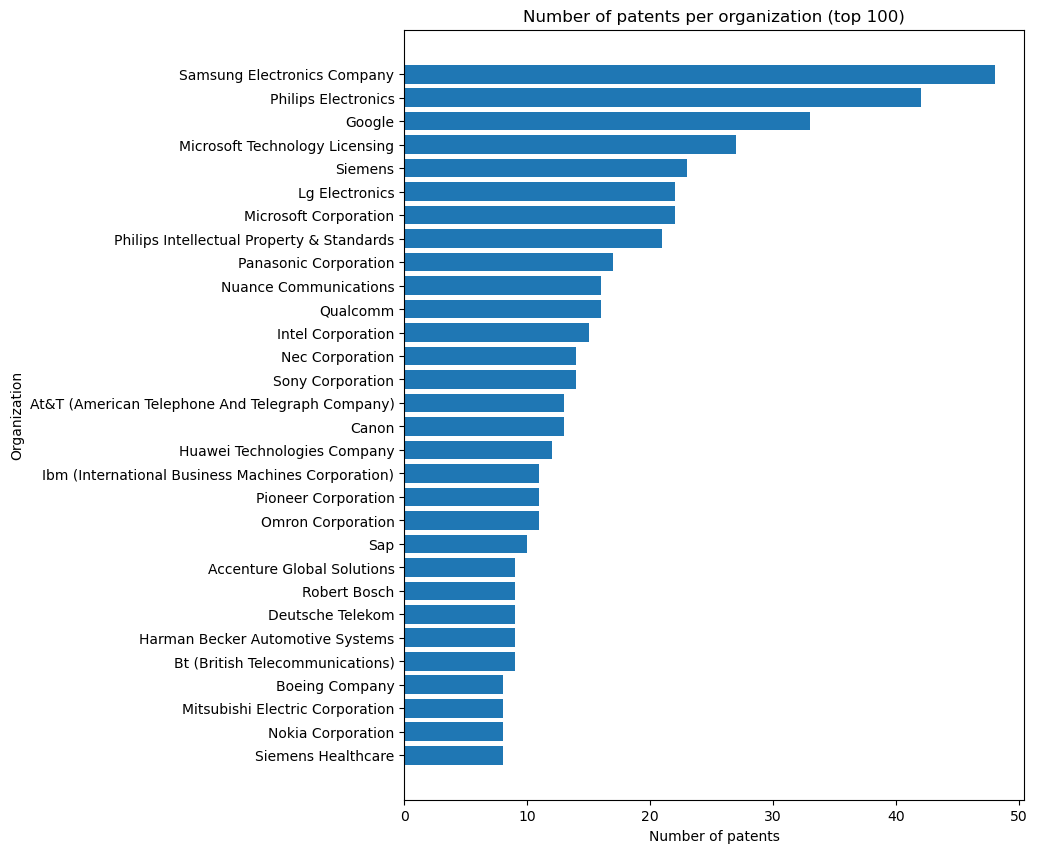

In [206]:
orgs, freqs = zip(*org_freq)

plt.figure(figsize=(8, 10))  
plt.barh(orgs[:30], freqs[:30])

plt.xlabel('Number of patents')
plt.ylabel('Organization')
plt.title('Number of patents per organization (top 100)')
plt.gca().invert_yaxis()  # Invert y axis

plt.show()

In [207]:
data = {
    "orgs" : orgs,
    "freqs" : freqs
}

with open(indicators_dir.joinpath("Technology_2_2.pickle"), "wb") as fout:
    pickle.dump(data, fout)

In [208]:
# Save
jstruct.set_info(orgs, freqs, ind="i09", sv="organization")
jstruct.save()

#### 2.3.3. Patents by sector

In [209]:
PATSTAT_sector = PATSTAT_selected_person.filter(PATSTAT_selected_person["psn_sector"].isNotNull()).filter(PATSTAT_selected_person["psn_sector"]!="UNKNOWN").select("psn_sector")
sector_freq = PATSTAT_sector.groupBy("psn_sector").agg(F.count("*").alias("counts")).rdd.collectAsMap()

In [210]:
# Sort results
sector_freq  = sorted([(el[0].title(), el[1]) for el in sector_freq.items()], key=lambda x: -x[1])[:100]

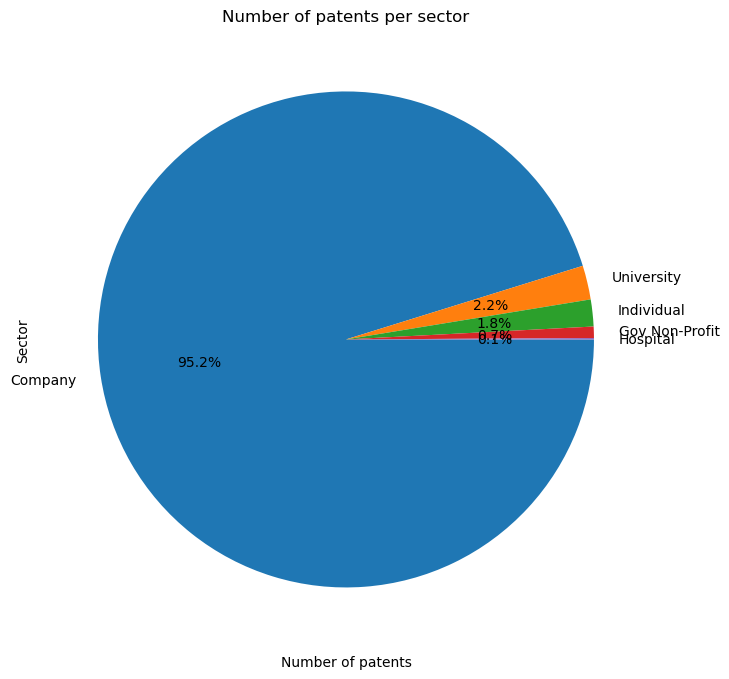

In [211]:
sector, freqs = zip(*sector_freq)

plt.figure(figsize=(8, 10))  
plt.pie(freqs, labels=sector, autopct='%1.1f%%')

plt.xlabel('Number of patents')
plt.ylabel('Sector')
plt.title('Number of patents per sector')
plt.gca().invert_yaxis()  # Invert y axis

plt.show()

In [212]:
data = {
    "sector" : sector,
    "freqs" : freqs
}

with open(indicators_dir.joinpath("Technology_2_3.pickle"), "wb") as fout:
    pickle.dump(data, fout)

In [213]:
# Save
jstruct.set_info(sector, freqs, ind="i09", sv="sector of organization")
jstruct.save()

### 2.4. Technological production characteristics

#### 2.4.1. Patents by NACE code

In [229]:
# Enrich patents with NACE information

tls229 = spark.read.parquet(path2PATSTAT + "tls229.parquet")
PATSTAT_selected_NACE = PATSTAT_selected.join(tls229, on="appln_id", how="inner")

tls902 = spark.read.parquet(path2PATSTAT + "tls902.parquet").select(["nace2_code", "nace2_descr"]).dropDuplicates()
PATSTAT_selected_NACE = PATSTAT_selected_NACE.join(tls902, on="nace2_code", how="inner").cache()

print("Number of patents incorporating NACE information:", PATSTAT_selected_NACE.count())
PATSTAT_selected_NACE.printSchema()
PATSTAT_selected_NACE.show(n=2, truncate=120, vertical=True)

Number of patents incorporating NACE information: 1686
root
 |-- nace2_code: string (nullable = true)
 |-- appln_id: string (nullable = true)
 |-- docdb_family_id: string (nullable = true)
 |-- appln_title: string (nullable = true)
 |-- appln_title_lg: string (nullable = true)
 |-- appln_abstract: string (nullable = true)
 |-- appln_abstract_lg: string (nullable = true)
 |-- appln_filing_year: string (nullable = true)
 |-- earliest_filing_year: integer (nullable = true)
 |-- granted: string (nullable = true)
 |-- appln_auth: string (nullable = true)
 |-- receiving_office: string (nullable = true)
 |-- ipr_type: string (nullable = true)
 |-- Kwd_count: integer (nullable = true)
 |-- weight: string (nullable = true)
 |-- nace2_descr: string (nullable = true)

-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------
 nace2_code           | 28.23                                                         

23/09/21 23:00:21 WARN CacheManager: Asked to cache already cached data.


In [232]:
PATSTAT_selected_NACE = PATSTAT_selected_NACE.withColumn("nace_out", F.concat_ws(" - ", PATSTAT_selected_NACE["nace2_code"], PATSTAT_selected_NACE["nace2_descr"]))
PATSTAT_selected_NACE = PATSTAT_selected_NACE.select(["nace_out", "weight"])

In [235]:
NACE_freq = PATSTAT_selected_NACE.groupBy("nace_out").agg(F.sum("weight").alias("total_weight")).rdd.collectAsMap()

In [236]:
NACE_freq

{'27.9 - Manufacture of other electrical equipment': 5.905598488000001,
 '30 - Manufacture of Other Transport Equipment': 1.93253971,
 '26.51 - Manufacture of Instruments and Appliances for Measuring, Testing and Navigation': 23.192857209999996,
 '28.1 - Manufacture of General-Purpose Machinery': 9.70555561,
 '29.1 - Manufacture of Motor Vehicles': 12.209920739999998,
 '26.2 - Manufacture of computers and peripheral equipment': 255.46355046699998,
 '62 - Computer Programming, Consultancy and Related Activities': 5.735750405999999,
 '32.5 - Manufacture of medical and dental instruments and supplies': 13.39444456,
 '29.3 - Manufacture of Parts and Accessories for Motor Vehicles': 3.4833333399999997,
 '26.3 - Manufacture of Communication Equipment': 118.39044005,
 '28.23 - Manufacture of Office Machinery and Equipment (Except Computers and Peripheral Equipment)': 469.513272806,
 '27.9 - Manufacture of Other Electrical Equipment': 5.905598488000001,
 '28.4 - Manufacture of Metal Forming Ma

In [238]:
# Sort results
NACE_freq  = sorted([(el[0].title(), el[1]) for el in NACE_freq.items()], key=lambda x: -x[1])[:100]

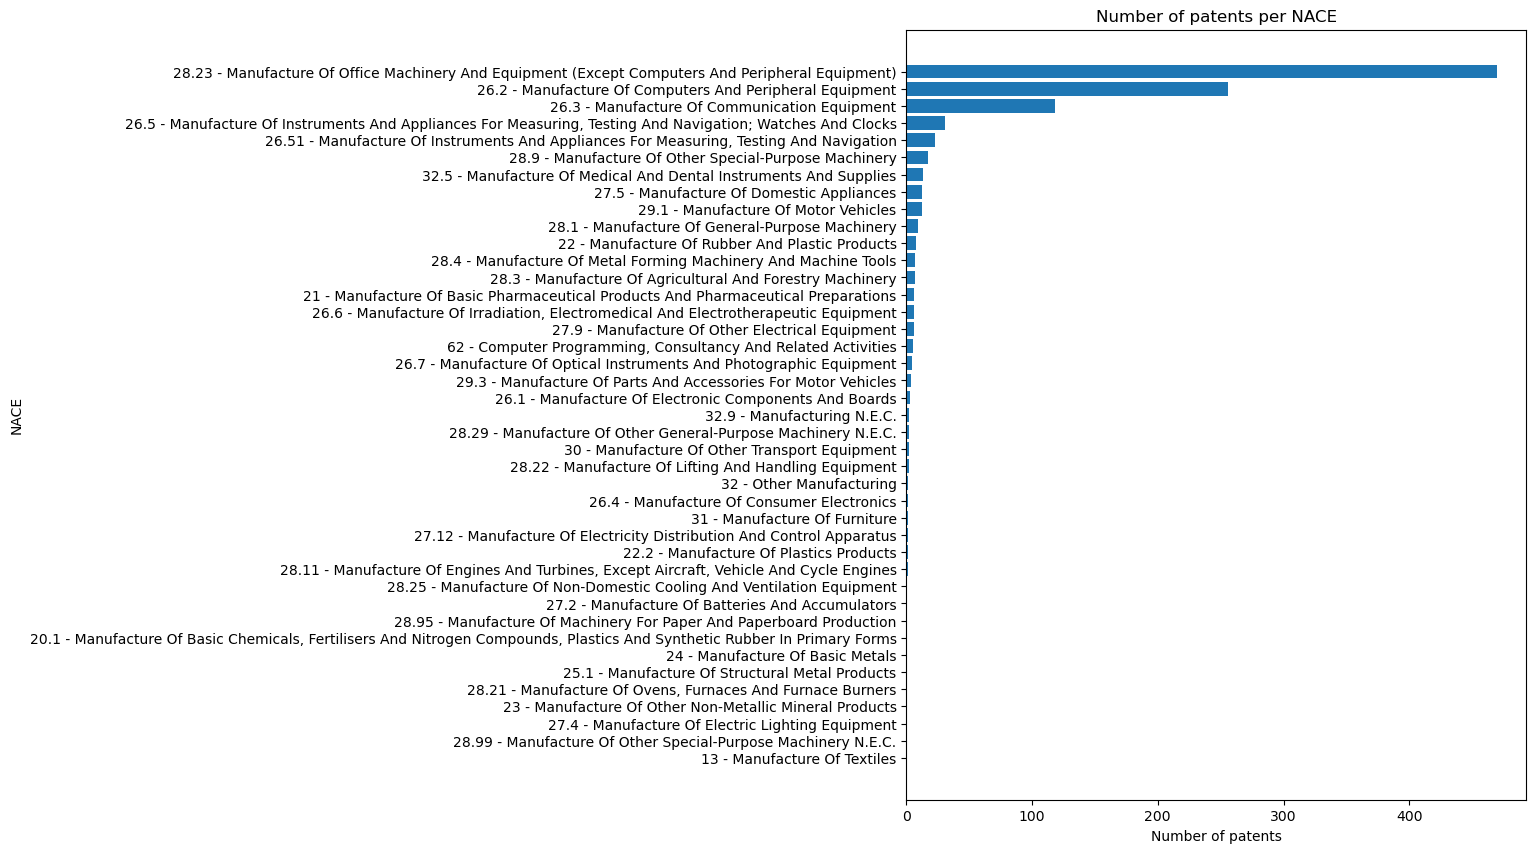

In [239]:
NACE, freqs = zip(*NACE_freq)

plt.figure(figsize=(8, 10))  
plt.barh(NACE, freqs)

plt.xlabel('Number of patents')
plt.ylabel('NACE')
plt.title('Number of patents per NACE')
plt.gca().invert_yaxis()  # Invert y axis

plt.show()

In [240]:
data = {
    "NACE" : NACE,
    "freqs" : freqs
}

with open(indicators_dir.joinpath("Technology_3_1.pickle"), "wb") as fout:
    pickle.dump(data, fout)

In [242]:
# Save
jstruct.set_info(NACE, freqs, ind="i09", sv="NACE of companies")
jstruct.save()

#### 2.4.2. Patents by IPC codes (top 20 codes)

In [267]:
# Enrich patents with IPC information

tls209 = spark.read.parquet(path2PATSTAT + "tls209.parquet").select(["appln_id", "ipc_class_symbol"])
PATSTAT_selected_IPC = PATSTAT_selected.join(tls209, on="appln_id", how="inner")
PATSTAT_selected_IPC = PATSTAT_selected_IPC.withColumn("IPC", F.substring(F.col("ipc_class_symbol"), 1, 3))
PATSTAT_selected_IPC = PATSTAT_selected_IPC.select(["appln_id", "IPC"]).dropDuplicates()

In [268]:
IPC_freq = PATSTAT_selected_IPC.groupBy("IPC").agg(F.count("*").alias("counts")).rdd.collectAsMap()

In [273]:
IPC_descriptions = {
    "G10" : "G10 - MUSICAL INSTRUMENTS; ACOUSTICS",
    "G06" : "G06 - COMPUTING; CALCULATING OR COUNTING",
    "H04" : "H04 - ELECTRIC COMMUNICATION TECHNIQUE",
    "G01" : "G01 - MEASURING; TESTING",
    "G05" : "G05 - CONTROLLING; REGULATING",
    "A61" : "A61 - MEDICAL OR VETERINARY SCIENCE; HYGIENE",
    "B60" : "B60 - VEHICLES IN GENERAL"
    }

IPC_descriptions = {el[0] : el[1].title() for el in IPC_descriptions.items()}

In [274]:
IPC_freq_desc = {}

for el in IPC_freq:
    if el in IPC_descriptions:
        IPC_freq_desc[IPC_descriptions[el]] = IPC_freq[el]
    else:
        IPC_freq_desc[el] = IPC_freq[el]

In [275]:
# Sort results
IPC_freq_desc  = sorted([(el[0].title(), el[1]) for el in IPC_freq_desc.items()], key=lambda x: -x[1])

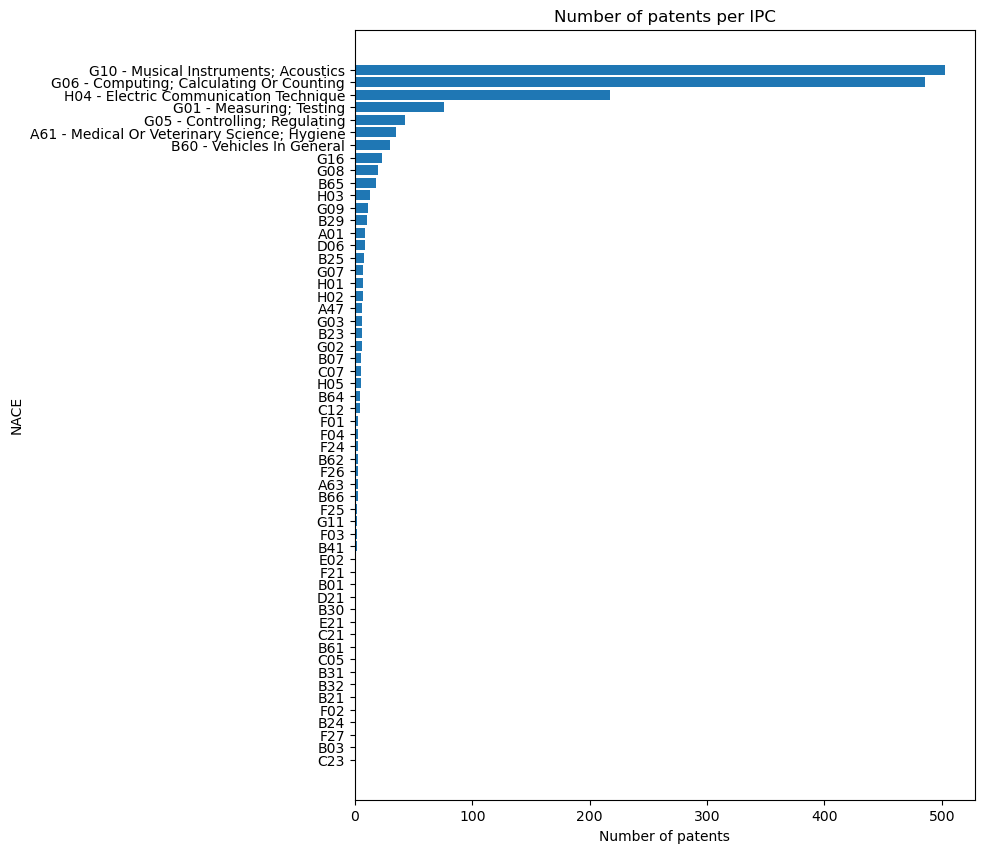

In [276]:
IPC, freqs = zip(*IPC_freq_desc)

plt.figure(figsize=(8, 10))  
plt.barh(IPC, freqs)

plt.xlabel('Number of patents')
plt.ylabel('NACE')
plt.title('Number of patents per IPC')
plt.gca().invert_yaxis()  # Invert y axis

plt.show()

In [277]:
data = {
    "IPC" : IPC,
    "freqs" : freqs
}

with open(indicators_dir.joinpath("Technology_3_2.pickle"), "wb") as fout:
    pickle.dump(data, fout)

In [278]:
# Save
jstruct.set_info(IPC, freqs, ind="i09", sv="IPC/CPC code")
jstruct.save()

#### 2.4.3. Patents by topic

In [279]:
patents_id = PATSTAT_selected.select("appln_id").rdd.flatMap(lambda x: x).collect()
patents_id = set(patents_id)
pos = [idx for idx,val in enumerate(corpus_LDA) if val in patents_id]
patents_per_topic = np.sum(thetas_LDA[pos,:], axis=0).tolist()[0]

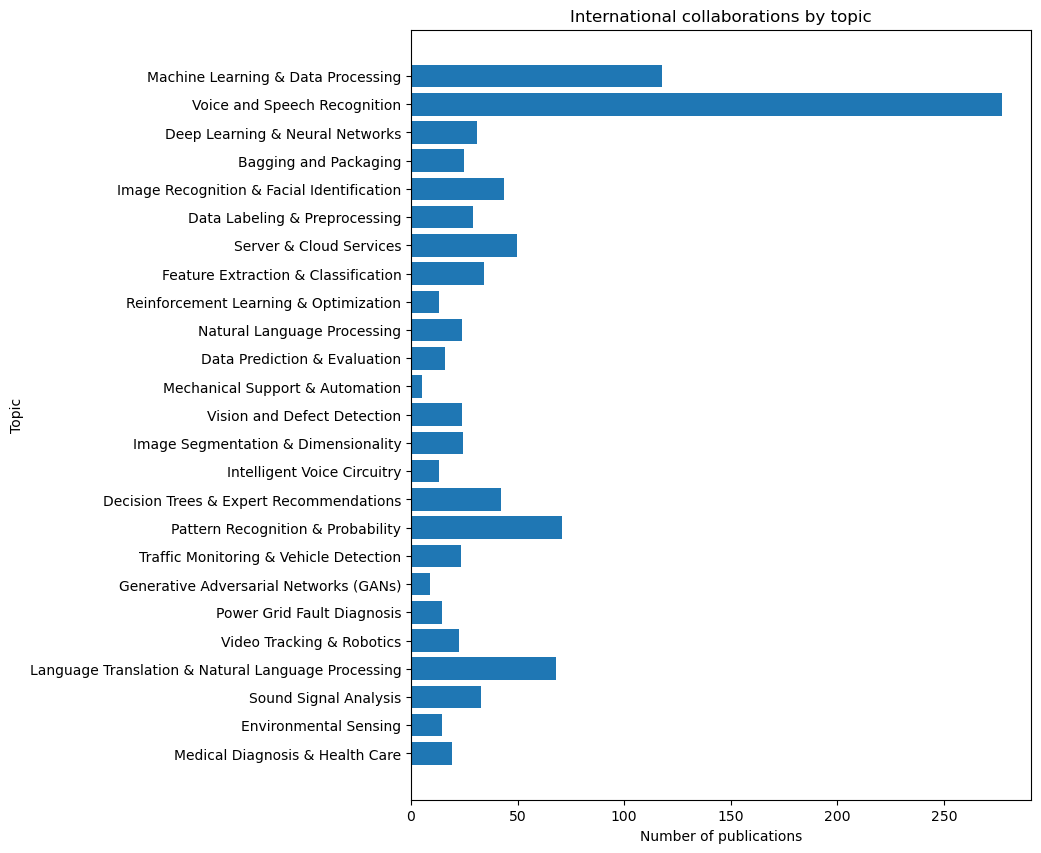

In [280]:
plt.figure(figsize=(8, 10))
plt.barh(topics_LDA, patents_per_topic)

plt.xlabel('Number of publications')
plt.ylabel('Topic')
plt.title('International collaborations by topic')
plt.gca().invert_yaxis()  # Invert axis

plt.show()

In [281]:
data = {
    "topics_LDA": topics_LDA,
    "patents_per_topic" : patents_per_topic
}

with open(indicators_dir.joinpath("Technology_3_3.pickle"), "wb") as fout:
    pickle.dump(data, fout)

In [282]:
# Save
jstruct.set_info(topics_LDA, patents_per_topic, ind="i09", sv="topic")
jstruct.save()